# OCR Cookbook

---

## OCR Exploration and Structured Outputs
In this cookbook, we will explore the basics of OCR and leverage it together with existing models to achieve structured outputs fueled by our OCR model.

You may want to do this in case current vision models are not powerful enough, hence enhancing their vision OCR capabilities with the OCR model to achieve better structured data extraction.

---

### Used
- Mistral OCR
- Pixtral 12B & Ministral 8B


### Setup
First, let's install `mistralai` and download the required files.

In [1]:
!pip install mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 9.4 MB/s eta 0:00:00


In [2]:
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/mistral7b.pdf
!wget https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/receipt.png

--2025-03-13 03:31:04--  https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/mistral7b.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3749788 (3.6M) [application/octet-stream]
Saving to: ‘mistral7b.pdf’

mistral7b.pdf       100%[===================>]   3.58M  --.-KB/s    in 0.08s   

2025-03-13 03:31:04 (44.5 MB/s) - ‘mistral7b.pdf’ saved [3749788/3749788]

--2025-03-13 03:31:04--  https://raw.githubusercontent.com/mistralai/cookbook/refs/heads/main/mistral/ocr/receipt.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting res

We can now set up our client. You can create an API key on our [Plateforme](https://console.mistral.ai/api-keys/).

In [3]:
from mistralai import Mistral

api_key = "M3ygQZKwgMjcYgSkKaX47HxGFlyXbNtO"
client = Mistral(api_key=api_key)

There are two types of files you can apply OCR to:
- PDF files, either uploaded or from URLs...

In [4]:
from pathlib import Path

pdf_file = Path("/content/Google Titans.pdf")
assert pdf_file.is_file()

{
    "pages": [
        {
            "index": 0,
            "markdown": "# Titans: Learning to Memorize at Test Time \n\nAli Behrouz ${ }^{\\dagger}$, Peilin Zhong ${ }^{\\dagger}$, and Vahab Mirrokni ${ }^{\\dagger}$<br>${ }^{\\dagger}$ Google Research<br>\\{alibehrouz, peilinz, mirrokni\\}@google.com\n\n\n#### Abstract\n\nOver more than a decade there has been an extensive research effort of how effectively utilize recurrent models and attentions. While recurrent models aim to compress the data into a fixed-size memory (called hidden state), attention allows attending to the entire context window, capturing the direct dependencies of all tokens. This more accurate modeling of dependencies, however, comes with a quadratic cost, limiting the model to a fixed-length context. We present a new neural long-term memory module that learns to memorize historical context and helps an attention to attend to the current context while utilizing long past information. We show that this neural m
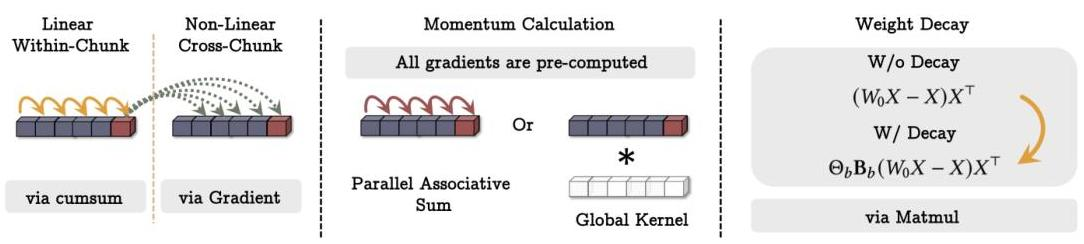
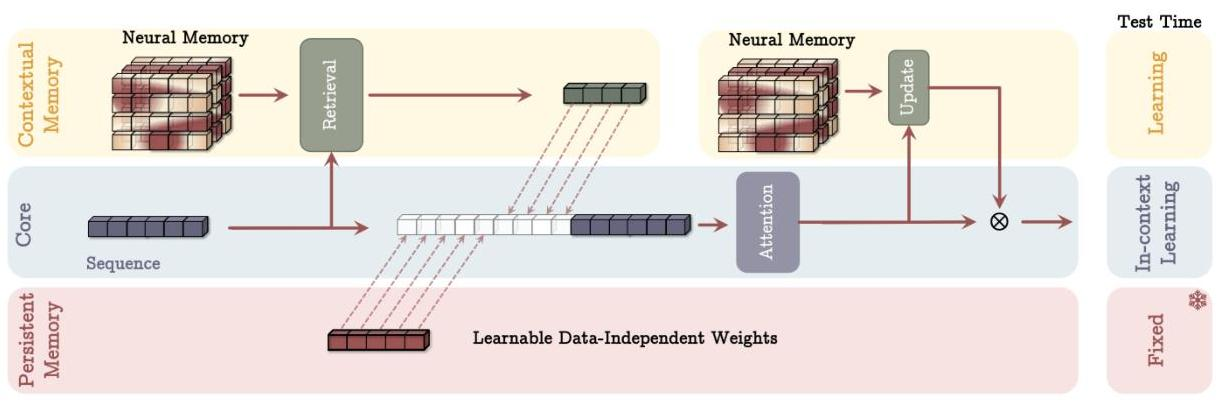
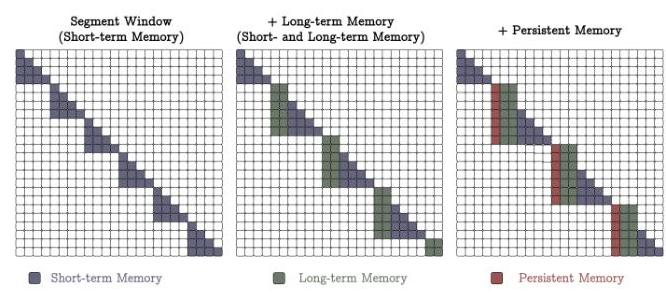
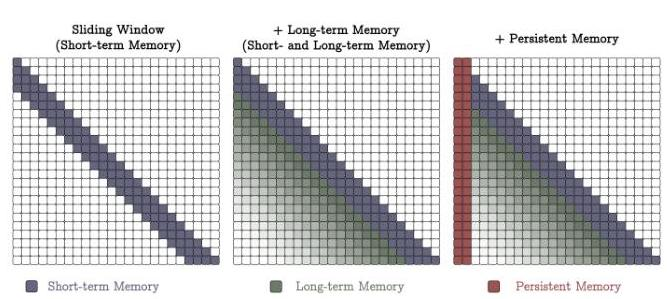
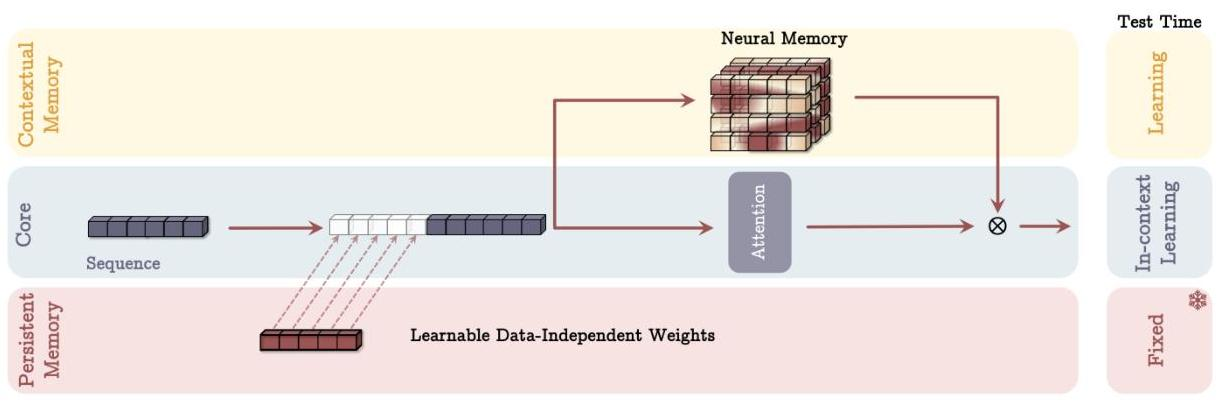
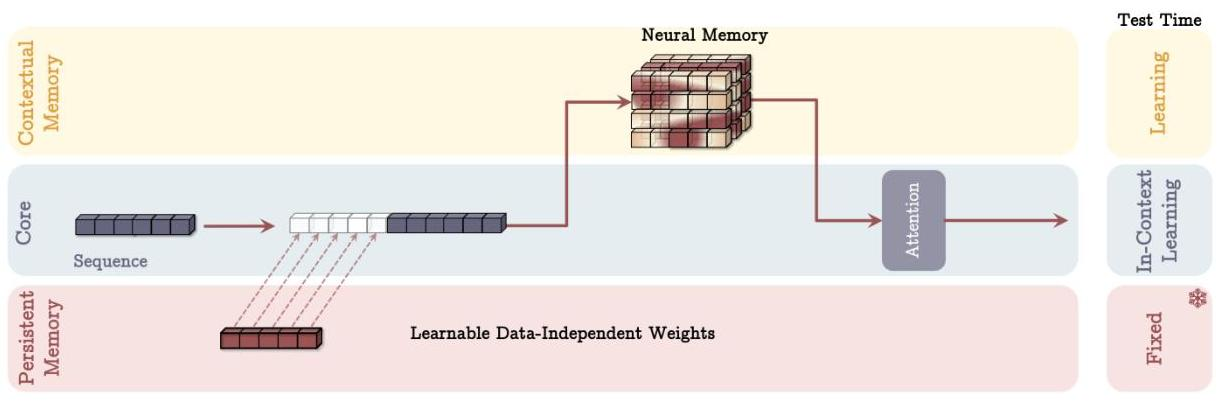
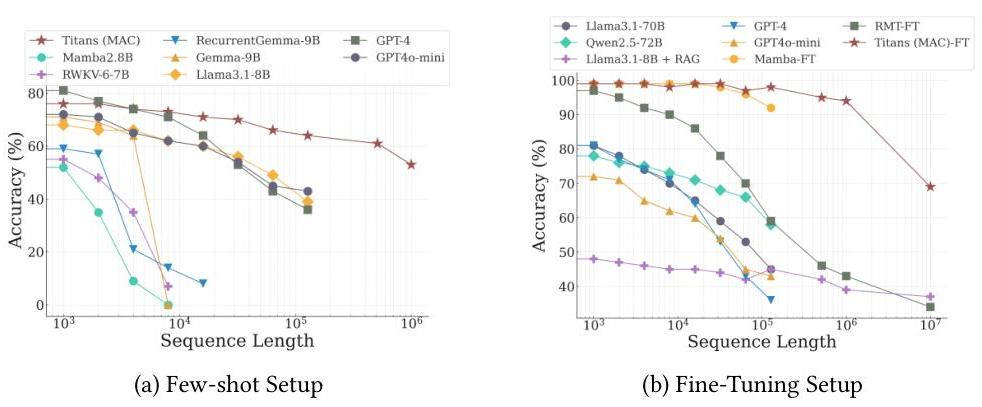
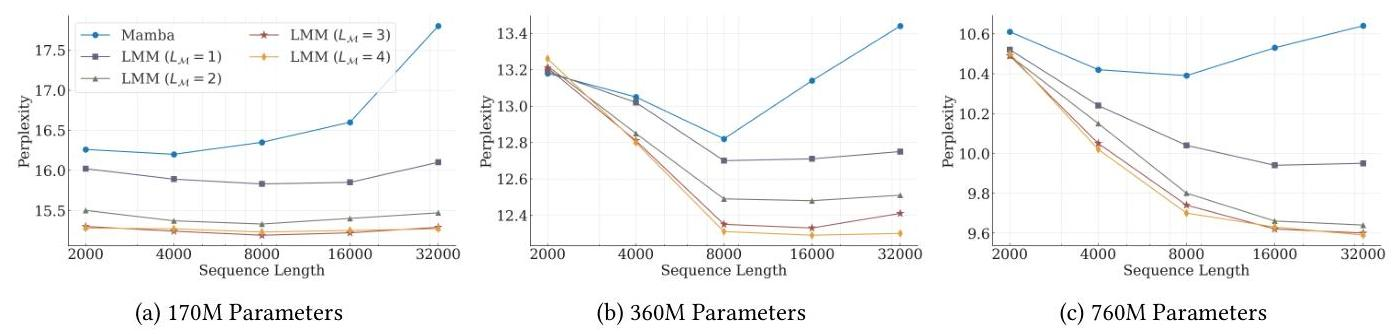
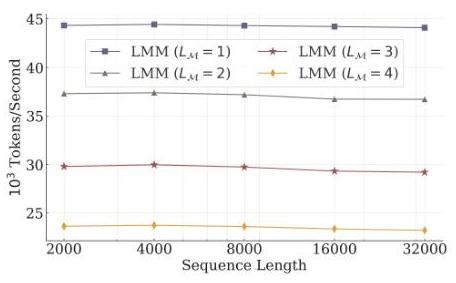
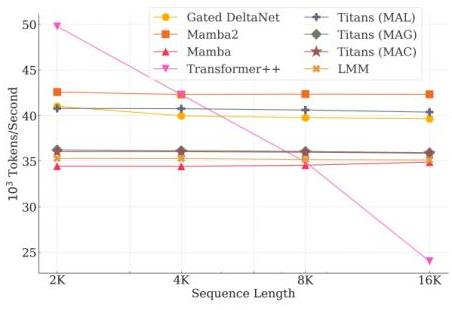

<ipython-input-6-793982fc17e2>:16: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  response_dict = json.loads(pdf_response.json())


In [6]:
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk
import json

uploaded_file = client.files.upload(
    file={
        "file_name": pdf_file.stem,
        "content": pdf_file.read_bytes(),
    },
    purpose="ocr",
)

signed_url = client.files.get_signed_url(file_id=uploaded_file.id, expiry=1)

pdf_response = client.ocr.process(document=DocumentURLChunk(document_url=signed_url.url), model="mistral-ocr-latest", include_image_base64=True)

response_dict = json.loads(pdf_response.json())
json_string = json.dumps(response_dict, indent=4)
print(json_string)

*The OCR model can output interleaved text and images (set `include_image_base64=True` to return the base64 image ), we can view the result with the following:*

# Titans: Learning to Memorize at Test Time 

Ali Behrouz ${ }^{\dagger}$, Peilin Zhong ${ }^{\dagger}$, and Vahab Mirrokni ${ }^{\dagger}$<br>${ }^{\dagger}$ Google Research<br>\{alibehrouz, peilinz, mirrokni\}@google.com


#### Abstract

Over more than a decade there has been an extensive research effort of how effectively utilize recurrent models and attentions. While recurrent models aim to compress the data into a fixed-size memory (called hidden state), attention allows attending to the entire context window, capturing the direct dependencies of all tokens. This more accurate modeling of dependencies, however, comes with a quadratic cost, limiting the model to a fixed-length context. We present a new neural long-term memory module that learns to memorize historical context and helps an attention to attend to the current context while utilizing long past information. We show that this neural memory has the advantage of a fast parallelizable training while maintaining a fast inference. From a memory perspective, we argue that attention due to its limited context but accurate dependency modeling performs as a short-term memory, while neural memory due to its ability to memorize the data, acts as a long-term, more persistent, memory. Based on these two modules, we introduce a new family of architectures, called Titans, and present three variants to address how one can effectively incorporate memory into this architecture. Our experimental results on language modeling, common-sense reasoning, genomics, and time series tasks show that Titans are more effective than Transformers and recent modern linear recurrent models. They further can effectively scale to larger than 2 M context window size with higher accuracy in needle-in-haystack tasks compared to baselines.


## 1 Introduction

"The true art of memory is the art of attention!"

- Samuel Johnson, 1787

 Transformers, pure attention-based architectures (Vaswani et al. 2017), have been firmly established as state-of-the-art models in sequence modeling, mainly due to their in-context learning and ability to learn at scale (Kaplan et al. 2020). The primary building blocks of Transformers-attention modules-function as associative memory blocks (Bietti et al. 2024), where they learn to store key-value associations and retrieve them by computing pairwise similarity between queries (i.e., search signals) and keys (i.e., contexts). Accordingly, by design, the output of a Transformer is exclusively conditioned on the direct dependencies of tokens in the current context window. This accurate modeling of dependencies, however, comes with quadratic time and memory complexity in terms of the context length. In complex real-world tasks (e.g., language modeling (N. F. Liu et al. 2024), video understanding (C.-Y. Wu et al. 2019), long-term time series forecasting (H. Zhou et al. 2021)), the context window can become extremely large, making the applicability of Transformers challenging in these downstream tasks.

To overcome the scalability issue of Transformers, recent studies aim to design different variants of linear Transformers (Kacham, Mirrokni, and P. Zhong 2024; Katharopoulos et al. 2020; S. Yang, B. Wang, Shen, et al. 2024), where softmax is replaced by a kernel function in the attention (see $\S 2.1$ for details), resulting in a significant drop in memory consumption. Despite efficiency and the ability to scale to longer context, linear Transformers do not show competitive performance compared to Transformers as the kernel trick makes the model a linear recurrent network, in which the data is compressed into a matrix-valued states (Katharopoulos et al. 2020). This, however, brings a contradictory fact about linear recurrent (or linear Transformers) models: On one hand, we use these linear models to enhance scalability and efficiency (linear vs. quadratic complexity), whose advantages is appeared for very long context; On the other hand, a very long context cannot be properly compressed in a small vector-valued or matrix-valued states (S. Wang 2024).

Furthermore, beyond efficiency, most existing architectures-ranging from Hopfield Networks (Hopfield 1982) to LSTMs (Jürgen Schmidhuber and Hochreiter 1997) and Transformers (Vaswani et al. 2017)-face challenges when dealing with generalization, length extrapolation, and/or reasoning (Anil et al. 2022; Qin, Y. Zhong, and Deng 2024), all of which are inseparable parts of many hard real-world tasks. Although these architectures draw inspiration from the human brain, each of which are missing: (1) a crucial component for learning process-such as short-term memory, long-term memory, meta-memory, attending to current context, etc. (Cowan 2008); (2) how these components are interconnected systems that can operate independently; and/or (3) the ability to actively learn from data and memorize the abstraction of past history. We argue that in an effective learning paradigm, similar to human brain, there are distinct yet interconnected modules, each of which is responsible for a component crucial to the learning process.

# Memory Perspective 

Memory is a fundamental mental process and is an inseparable component of human learning (Terry 2017). Without a properly functioning memory system, humans and animals would be restricted to basic reflexes and stereotyped behaviors. Accordingly, memory has been the inspiration for many seminal research in machine learning literature; e.g., Hopfield Networks (Hopfield 1982), LSTMs (Jürgen Schmidhuber and Hochreiter 1997), and Transformers (Vaswani et al. 2017).

Taking inspiration from the common definitions of memory and learning in neuropsychology literature (Okano, Hirano, and Balaban 2000), most existing architectures consider memory as a neural update caused by an input, and define learning as a process for acquiring effective and useful memory, given an objective. In this perspective, Recurrent Neural Networks (RNNs) (Williams and Zipser 1989) can be defined as models with a vector-valued memory module $\mathcal{M}$ (also called hidden state) with two main steps: Given a new input $x_{t}$ at time $t$, the model (1) updates the memory using a function $f\left(\mathcal{M}_{t-1}, x_{t}\right)$ (with compression); and (2) retrieves the corresponding memory of input using a function $g\left(\mathcal{M}_{t}, x_{t}\right)$ (see $\S 2.1$ for details). Similarly, Transformers can be seen as architectures with a growing memory and two similar steps. That is, the pair of key and value matrices acts as the model's memory, and the model: (1) updates the memory by appending the key and value to the memory (without compression), and (2) retrieves query vectors' corresponding memory by finding the similarity of query and key vectors, which is then used to weight the value vectors for the output.

This perspective, can help us better understand existing paradigms, their critical differences, and design more effective architectures. For example, the main difference between Transformers (Vaswani et al. 2017) and linear Transformers (Katharopoulos et al. 2020) is the memory structure as well as the memory updating step, in which linear Transformers compress the historical data into a fixed-size matrix-valued memory while Transformers keep all historical data (within the context length) without any compression. While both linear Transformers and linear RNNs (including state space models) compress the information in memory update step, the critical difference lies in the structure of the memory, where linear RNNs (vs. linear Transformers) use a vector-valued memory (vs. matrix-valued memory). Therefore, this perspective motivates us to ask: (Q1) What constitute a good structure for the memory? (Q2) What is a proper memory update mechanism? and (Q3) What is a good memory retrieval process?

Revisiting our understanding of human memory, it is neither a unitary process nor it serves a single function (Cowan 2008). In fact, memory is a confederation of systems-e.g., short-term, working, and long-term memory-each serving a different function with different neural structures, and each capable of operating independently (Willingham 1997). This fact motivates us to ask: (Q4) How to design an efficient architecture that incorporates different interconnected memory modules. Finally, storing a memory is a neural process that requires to encode and store the abstraction of the past. It can be over-simplification to assume a single vector or a matrix, whose parameters are encoding the data in a linear manner, are enough for storing long-term history. (Q5) Is a deep memory module needed to effectively store/remember long past?

## Contributions and Roadmap

In this paper, we aim to answer the above five questions by designing a long-term neural memory module, that can efficiently and effectively learn to memorize at test time. Building upon its design, we discuss how it can be incorporated into an architecture.

Neural Memory (§3). We present a (deep) neural long-term memory that (as a meta in-context model) learns how to memorize/store the data into its parameters at test time. Inspired by human long-term memory system (Mandler 2014),

we design this memory module so an event that violates the expectations (being surprising) is more memorable. To this end, we measure the surprise of an input with the gradient of the neural network with respect to the input in associative memory loss (see $\S 3.1$ for details). To better handle the limited memory, we present a decaying mechanism that consider the proportion of memory size and the amount of data surprise, resulting in better memory management. We show that this decay mechanism is in fact the generalization of forgetting mechanism in modern recurrent models (Dao and Gu 2024; Gu and Dao 2024; S. Yang, Kautz, and Hatamizadeh 2024). Interestingly, we find that this mechanism is equivalent to optimizing a meta neural network with mini-batch gradient descent, momentum, and weight decay. Building upon tensorizing mini-batch gradient descent to use more matmul operations (Yu Sun et al. 2024), we present a fast and parallelizable algorithm to train our deep neural long-term memory.

Titans Architectures (§4). After designing the long-term neural memory, an important remaining question is how to effectively and efficiently incorporate memory into a deep learning architecture. We present Titans, a family of deep models that consists of three hyper-heads: (1) Core: this module consists of the short-term memory, and is responsible for the main flow of processing the data (we use attention with limited window size); (2) Long-term Memory: this branch is our neural long-term memory module that is responsible to store/remember long past; (3) Persistent Memory: this is a set of learnable but date-independent parameters that encodes the knowledge about a task. Finally, as a proof of concept, we present three variants of Titans, in which we incorporate memory as: (i) a context, (ii) a layer, and (iii) a gated branch.

Experimental Results (§5). We perform experimental evaluations on language modeling, commonsense reasoning, recallintensive, needle in haystack, time series forecasting, and DNA modeling tasks. We observe that our Titan architecture outperforms all modern recurrent models as well as their hybrid variants (combining with sliding-window attention) across a comprehensive set of benchmarks. Furthermore, Titans outperforms Transformers with the same context window, and show competitive performance with Transformers that use the entire context. This results are achieved while, contrary to Transformers, Titans scale to larger than 2 M context window size.

# 2 Preliminaries 

$\stackrel{\text { ® }}{\stackrel{\text { ® }}{\leftrightarrows}}$n this section, we discuss the notation and some background concepts that we use though the paper. We let $x \in \mathbb{R}^{N \times d_{\text {in }}}$ be the input, $\mathcal{M}$ be a neural network (neural memory module), $\mathbf{Q}, \mathbf{K}, \mathbf{V}$ be the query, key and value of the attention mechanism, and $\mathbf{M}$ be the attention mask. When segmenting the sequence, we use $S^{(i)}$ to refer to the $i$-th segment. Through the paper, we abuse the notation and use subscripts to refer to a specific element of a matrix, vector, or segments. For example, we let $S_{j}^{(i)}$ be the $j$-th token in the $i$-th segment. The only exception is subscripts with $t$, which we reserved to index recurrence over time, or the state of a neural network at time $t$. Given a neural network $\mathcal{N}$ and a data sample $x$, we use $\mathcal{N}(x)$ (resp. $\mathcal{N}^{*}(x)$ ) to refer to the forward pass with (resp. without) weight adjustment. Also, we abuse the notation and use $\mathcal{N}^{(k)}$ to refer to the $k$-th layer of the neural network. In the following, we first, discuss the backgrounds for attention and its efficient variants followed by a review of modern linear RNNs. Finally, we discuss a memory perspective of these architectures that motivates us to design Titans.

### 2.1 Backgrounds

Attention. Transformers (Vaswani et al. 2017) as the de facto backbone for many deep learning models are based on attention mechanism. Given input $x \in \mathbb{R}^{N \times d_{\text {in }}}$, causal attention computes output $\mathbf{y} \in \mathbb{R}^{N \times d_{\text {in }}}$ based on softmax over input dependent key, value, and query matrices:

$$
\begin{gathered}
\mathbf{Q}=x \mathbf{W}_{\mathbf{Q}}, \quad \mathbf{K}=x \mathbf{W}_{\mathbf{K}}, \quad \mathbf{V}=x \mathbf{W}_{\mathbf{V}} \\
\mathbf{y}_{i}=\sum_{j=1}^{i} \frac{\exp \left(\mathbf{Q}_{j}^{\top} \mathbf{K}_{j} / \sqrt{d_{\text {in }}}\right) \mathbf{V}_{j}}{\sum_{l=1}^{i} \exp \left(\mathbf{Q}_{l}^{\top} \mathbf{K}_{l} / \sqrt{d_{\text {in }}}\right)}
\end{gathered}
$$

where $\mathbf{W}_{\mathbf{Q}}, \mathbf{W}_{\mathbf{K}}$, and $\mathbf{W}_{\mathbf{V}} \in \mathbb{R}^{d_{\text {in }} \times d_{\text {in }}}$ are learnable parameters. Despite the power and effectiveness in recall, transformers need at least $N \times d$ operators to calculate the output, resulting in larger memory consumption and lower-throughput for longer sequences.

Efficient Attentions. To improve the memory consumption and throughput of softmax attention for longer sequences, various studies focused on I/O aware implementations of attention (Dao 2024; Dao, D. Fu, et al. 2022), designing more

efficient attention mechanisms by sparsifying the attention matrix (B. Chen et al. 2021; Choromanski et al. 2021; Dai et al. 2019), approximating the softmax (Arora et al. 2024), or developing kernel-based (linear) attentions (Aksenov et al. 2024; Kacham, Mirrokni, and P. Zhong 2024; Schlag, Irie, and Jürgen Schmidhuber 2021; S. Yang, B. Wang, Shen, et al. 2024). In this part, we focus on the later, i.e., linear attentions, where the softmax in standard attention is replaced with an alternative kernel function $\phi(\ldots)$, such that $\phi(x, y)=\phi(x) \phi(y)$. Accordingly, the attention can be written as:

$$
\mathbf{y}_{t}=\sum_{j=1}^{l} \frac{\phi\left(Q_{i}^{\top} K_{j}\right)}{\sum_{f=1}^{t} \phi\left(Q_{i}^{\top} K_{f}\right)} V_{j}=\sum_{j=1}^{l} \frac{\phi\left(Q_{i}\right)^{\top} \phi\left(K_{j}\right)}{\sum_{f=1}^{t} \phi\left(Q_{i}\right)^{\top} \phi\left(K_{f}\right)} V_{j}=\frac{\phi\left(Q_{i}\right)^{\top} \sum_{j=1}^{l} \phi\left(K_{j}\right) V_{j}}{\phi\left(Q_{i}\right)^{\top} \sum_{f=1}^{t} \phi\left(K_{f}\right)}
$$

resulting in a higher-throughput as terms $\sum_{j=1}^{l} \phi\left(K_{j}\right)$ and $\sum_{f=1}^{t} \phi\left(K_{f}\right)$ are re-using in each step. When choosing the kernel as identity matrix (Yutao Sun et al. 2023), the above formulation can also be written in a recurrent format:

$$
\begin{aligned}
& \mathcal{M}_{t}=\mathcal{M}_{t-1}+K_{t}^{\top} V_{t} \\
& \mathbf{y}_{t}=Q_{t} \mathcal{M}_{t}
\end{aligned}
$$

which allows efficient inference for linear attentions.
Modern Linear Models and Their Memory Perspective. As discussed earlier, one can define learning as a process for acquiring effective and useful memory. Building upon this, one can see the hidden state of Recurrent Neural Networks (RNNs) as a memory unit, which the model aims to compress the information into. Accordingly, in a general form of recurrent neural network, the hidden state can be treated as a memory unit and the recurrence process can be split into the read and write operations in the memory unit. That is, we let $x \in \mathbb{R}^{N \times d_{\mathrm{m}}}$ be the input, $\mathcal{M} \in \mathbb{R}^{d}$ is the memory unit, and $\mathbf{y} \in \mathbb{R}^{d_{\mathrm{m}}}$ is the output, then the general form of the recurrent neural network is defined as:

$$
\begin{array}{ll}
\mathcal{M}_{t}=f\left(\mathcal{M}_{t-1}, x_{t}\right), & \text { Write Operation } \\
\mathbf{y}_{t}=g\left(\mathcal{M}_{t}, x_{t}\right), & \text { Read Operation }
\end{array}
$$

where $f(\ldots)$ is the read and $g(.,$.$) is the write corresponding functions. Note that here the subscript of \mathcal{M}_{t}$ shows the state of the memory at time $t$.

In this perspective, the recurrence formula of linear Transformers (see Equation 4) is equivalent to additively compress and write keys and values, $\left(K_{t}, V_{t}\right)$, into a matrix-valued memory unit $\mathcal{M}_{t}$. Therefore, when dealing with long context data, this additive nature of the process results in memory overflow, significantly damaging the performance of the model. To address this, studies have focused on two promising directions: (1) Adding forget mechanism: several studies have presented adaptive (data-dependent) forgetting gate mechanisms for linear models, where it can erase the memory when it is needed. As examples of such models, we refer to GLA (S. Yang, B. Wang, Shen, et al. 2024), LRU (Orvieto et al. 2023), Griffin (De et al. 2024), xLSTM (Beck et al. 2024), and Mamba2 (Dao and Gu 2024), which the later is also connected to the discretized version of traditional state space models (Gu and Dao 2024).(2) Improving the write operation: To overcome the additive nature of memory write operation in traditional recurrent models, Widrow and Hoff (1988) presented Delta Rule, in which before adding a memory (i.e., a pair of key and value), the model first removes its past value. To enhance the parallelizable training and scaling, S. Yang, B. Wang, Yu Zhang, et al. (2024) present a fast paralellizable algorithm. Finally, very recently, S. Yang, Kautz, and Hatamizadeh (2024) improved the DeltaNets by adding a forget gate.

Memory Modules. Memory has always been one of the core parts of the neural network designs (Graves, Wayne, and Danihelka 2014; JH Schmidhuber 1992; Jürgen Schmidhuber and Hochreiter 1997; J. Zhang et al. 2024). The idea of seeing linear layers as the key-value (associative) memory system backs to fast weight programs, in which dynamic fast programs are incorporated into recurrent neural networks to serve as writable memory (JH Schmidhuber 1992). The two learning rules of Hebbian (Hebb 2005) and delta (Prados and Kak 1989) are the most popular learning rules for fast weight programs, which have been extensively explored in various studies (Irie, Schlag, et al. 2021; Munkhdalai, Sordoni, et al. 2019; Munkhdalai and H. Yu 2017; Schlag, Irie, and Jürgen Schmidhuber 2021; JH Schmidhuber 1992; S. Yang, Kautz, and Hatamizadeh 2024; S. Yang, B. Wang, Yu Zhang, et al. 2024). All these models, however, are based on momentary surprise, missing the token flow in the sequences (see Section 3.1), and most of them lacks a forgetting gate, resulting in a poor memory management.

We further discuss the connection of our architectures with recent models in Appendix C. Additional related work are discussed in Appendix A.

# 3 Learning to Memorize at Test Time 

000 overcome the lack of long-term memory and to enable the model to learn, forget, and retrieve information, in this section, we present a neural long-term memory module, which is a meta models that learns to memorize at test time. In Section 3.1, we first discuss the motivation and the design of the neural memory. In Section 3.2, we discuss how our architecture design can benefit from a fast and parallelizable training. Finally, in Section 3.3, we augment our architecture using persistent memory module, in which we use learnable but data-independent parameters to learn meta information about the task.

### 3.1 Long-term Memory

To design a neural long-term memory module, we need a model that can encode the abstraction of the past history into its parameters. An example of this can be LLMs that are shown to be memorizing their training data (Leybzon and Kervadec 2024; Schwarzschild et al. 2024; Staab et al. 2024). Therefore, a simple idea is to train a neural network and expect it to memorize its training data. Memorization, however, has almost always been known as an undesirable phenomena in neural networks as it limits the model generalization (Bayat et al. 2024), causes privacy concerns (Staab et al. 2024), and so results in poor performance at test time. Moreover, the memorization of the training data might not be helpful at test time, in which the data might be out-of-distribution. We argue that, we need an online meta-model that learns how to memorize/forget the data at test time. In this setup, the model is learning a function that is capable of memorization, but it is not overfitting to the training data, resulting in a better generalization at test time.

Learning Process and Surprise Metric. The key idea to train a long-term memory is to treat its training as an online learning problem, in which we aim to compress the past information $x_{1}, \ldots, x_{t-1}$ into the parameters of our long-term neural memory module $\mathcal{M}_{t}$. As discussed earlier, an event that violates the expectations (i.e., is surprising) is more memorable for humans (Mandler 2014). Inspired by this, a simple definition of surprise for a model can be its gradient with respect to the input. The larger the gradient is, the more different the input data is from the past data. Accordingly, using this surprise score, we can update the memory as:

$$
\mathcal{M}_{t}=\mathcal{M}_{t-1}-\theta_{t} \underbrace{\nabla \ell\left(\mathcal{M}_{t-1} ; x_{t}\right)}_{\text {Surprise }}
$$

This surprise metric, however, can result in missing important information that comes after a big surprising moment. That is, the gradient can become extremely small after several surprising steps, leading to stocking in a flat area (i.e., local minima), and missing information about some parts of the sequence. From the human memory perspective, an event might not consistently surprise us through a long-period of time although it is memorable. The reason is that the initial moment is surprising enough to get our attention through a long time frame, leading to memorizing the entire time frame. To improve the above surprise metric (Equation 8), we break the surprise metric into (1) past surprise, which measures the surprise amount of a very recent past; and (2) momentary surprise, which measures the surprise of incoming data:

$$
\begin{aligned}
& \mathcal{M}_{t}=\mathcal{M}_{t-1}+S_{t} \\
& S_{t}=\eta_{t} \underbrace{S_{t-1}}_{\text {Past Surprise }}-\theta_{t} \underbrace{\nabla \ell\left(M_{t-1} ; x_{t}\right)}_{\text {Momentary Surprise }}
\end{aligned}
$$

Interestingly, this formulation is similar to gradient descent with momentum, where $S_{t}$ is the momentum element. Therefore, the momentum here act as a memory of surprise across time (sequence length). In this formulation, the term $\eta_{t}$ is a data-dependent surprise decay (a function of $x_{t}$ ), controlling how surprise decays over time, and the term $\theta_{t}$ is controlling how much of momentary surprise should be incorporated into the final surprise metric in a data-dependent manner. This data-dependency is particularly important in this design: While surprise of previous tokens might be needed to affect the surprise of the next token, it is mostly valid if all tokens are relevant and are in the same context. Accordingly, a data-dependent $\eta$ can control if memory needs to: (1) ignore the last surprise by setting $\eta_{t} \rightarrow 0$ (possibly due to the change of context), or (2) fully incorporate the last surprise by setting $\eta_{t} \rightarrow 1$ (possibly as the token is highly relevant to its recent past tokens).

Objective. Our above surprise metric is based on a loss function $\ell\left(\cdot ;\right.$, which is the objective that our memory is learning to act as it at test time. That is, our memory module is a meta model that learns a function based on the loss function $\ell\left(\cdot ;\right.$.

In this work, we focus on associative memory, in which we aim to store the past data as the pairs of keys and values. Given $x_{t}$, similar to Transformers (Vaswani et al. 2017), we use two linear layers to project $x_{t}$ into a key and value:

$$
\mathbf{k}_{t}=x_{t} W_{K}, \quad \mathbf{v}_{t}=x_{t} W_{V}
$$

where $W_{K}$ and $W_{V} \in \mathbb{R}^{d_{\mathrm{in}} \times d_{\mathrm{in}}}$. Next, we expect our memory module to learn the associations between keys and values. To this end, we define the loss as follows:

$$
\ell\left(\mathcal{M}_{t-1} ; x_{t}\right)=\left\|\mathcal{M}_{t-1}\left(\mathbf{k}_{t}\right)-\mathbf{v}_{t}\right\|_{2}^{2}
$$

By optimizing the above loss function in the inner-loop of our meta model (memory), the model learns how to memorize the mapping between keys and values at test time. Note that, similar to meta-learning models (Nichol 2018; Zintgraf et al. 2019), training of the memory is in the inner-loop, and so parameters $W_{K}$ and $W_{V}$ are hyperparameters in the above loss function. Accordingly, in the inner loop, we optimize $\mathcal{M}$ 's weights, while in the outer-loop, we optimize other parameters of the entire architecture.

Forgetting Mechanism. When dealing with very large sequences (e.g., millions of tokens), it is crucial to manage which past information should be forgotten-even with a deep or a very large matrix-valued memory. To this end, we use an adaptive forgetting mechanism that allows the memory to forget the information that is not needed anymore, resulting in better managing the memory's limited capacity. That is, given the next token $x_{t}$, we modify the update rule as:

$$
\begin{aligned}
& \mathcal{M}_{t}=\left(1-\alpha_{t}\right) \mathcal{M}_{t-1}+S_{t} \\
& S_{t}=\eta_{t} S_{t-1}-\theta_{t} \nabla \ell\left(M_{t-1} ; x_{t}\right)
\end{aligned}
$$

where $\alpha_{t} \in[0,1]$ is the gating mechanism that flexibly controls the memory; i.e., decides how much information should be forgotten. For example, it can update the memory without affecting the past abstraction by letting $\alpha_{t} \rightarrow 0$, and can clear the entire memory by letting $\alpha_{t} \rightarrow 1$. Later in this section, we show that this weight decay mechanism is closely related to the gating mechanism in modern RNNs (Dao and Gu 2024; Orvieto et al. 2023).

Memory Architecture. In this paper, we focus on simple MLPs with $L_{\mathcal{M}} \geq 1$ layers as the architecture of our long-term memory. The main reason behind this choice is that we want to focus on better motivating the design of the long-term memory and ways that it can be incorporated into an architecture. However, our formulation and architectural design opens a new research direction to design neural architectures that are more effective and efficient in memorization of data. Recently, there has been a promising line of work to design such architectures (Berges et al. 2024; Cetin et al. 2024; J. Zhang et al. 2024), which incorporating them into our framework (i.e., replacing simple MLPs with such architectures) can be an interesting future work.

When using vector-valued or matrix-valued memory (De et al. 2024; Orvieto et al. 2023; S. Yang, B. Wang, Shen, et al. 2024), the memory module is compressing the past data and fit it into a line. That is, from the meta learning or online learning perspective (Yu Sun et al. 2024), using a matrix-valued memory $\mathcal{M}=W \in \mathbb{R}^{d_{\mathrm{in}} \times d_{\mathrm{in}}}$ is equivalent to optimize $\ell\left(W_{t-1} ; x_{t}\right)=\left\|W_{t-1} \mathbf{k}_{t}-\mathbf{v}_{t}\right\|_{2}^{2}$, which is an online linear regression objective and so the optimal solution assumes the underlying dependency of historical data is linear. On the other hand, we argue that deep memory modules (i.e., $L_{\mathcal{M}} \geq 2$ ). Aligning with the theoretical results that MLPs with at least two layers are strictly more expressive than linear models (Hornik, Stinchcombe, and White 1989), in Section 5.5, we show that deep memory modules are more effective in practice.

Retrieving a Memory. In the above, we discuss how one can design and train a long-term memory module that learns to memorize at test time. A key remaining question is: How one can retrieve information from the memory? We simply use the forward pass without weight update (i.e., inference) to retrieve a memory correspond to a query. Formally, given an input $x_{t}$, we use a linear layer $W_{Q}$ to project the input, i.e., $\mathbf{q}_{t}=x_{t} W_{Q}$ and retrieve the corresponding (or useful) information from the memory $y_{t}$ by:

$$
y_{t}=\mathcal{M}^{*}\left(\mathbf{q}_{t}\right)
$$

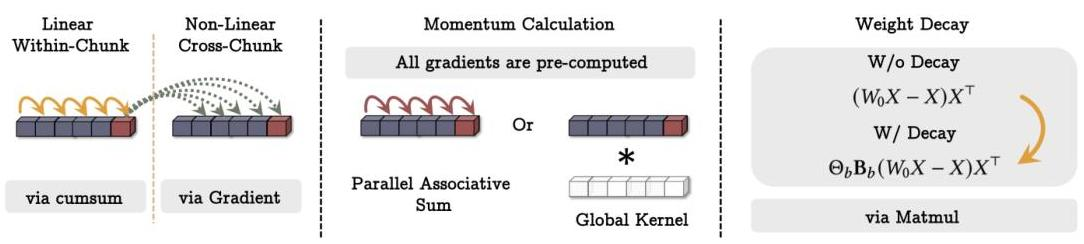

Figure 1: The illustration of how the training of neural memory can be done in parallel and using matmuls.

# 3.2 How to Parallelize the Long-term Memory Training 

As discussed above, the design of our long-term memory module is equivalent to training a meta model by optimizing associative memory loss function $\ell\left(\mathcal{M}_{t-1} ; x_{t}\right)=\left\|\mathcal{M}_{t-1}\left(\mathbf{k}_{t}\right)-\mathbf{v}_{t}\right\|_{2}^{2}$ using gradient descent with momentum and weight decay. Therefore, in theory, the training of long-term memory module requires $\mathcal{O}(N)$ FLOPs, where $N$ is the sequence length. However, in practice, we need to parallelize the training process and to fully take advantage of hardware accelerators (e.g., TPUs, GPUs), we need to tensorize the process and use more matmuls.

Next, we show that calculating the weights in the inner loop with mini-batch gradient descent, data-dependent learning rate, and weight decay can be reformulated so that it uses only matmuls and sum. We build upon the work of Yu Sun et al. (2024) that shows forward pass of a model optimizing with the mini-batch gradient descent (with constant learning rate) can be calculated using matmuls. We can split the sequence into chunks of size $b \geq 1$, and write the mini-batch gradient descent as:

$$
\mathcal{M}_{t}=\left(1-\alpha_{t}\right) \mathcal{M}_{t-1}-\theta_{t} \nabla \ell\left(\mathcal{M}_{t-1} ; x_{t}\right)=\beta_{t} \mathcal{M}_{0}-\sum_{i=1}^{t} \theta_{i} \frac{\beta_{i}}{\beta_{t}} \nabla \ell\left(\mathcal{M}_{t^{\prime}} ; x_{i}\right)
$$

where $t^{\prime}=t-\bmod (t, b)$, and $\beta_{i}=\prod_{j=1}^{t}\left(1-\alpha_{j}\right)$. For the sake of simplicity, we focus on the first chunk, i.e., $t=b$ and so $t^{\prime}=0$. Also, we explain the process for the case that $\mathcal{M}_{t}=W_{t}$ is linear. The process for MLPs with $N_{p} \geq 2$ is similar. Using our loss function, we have:

$$
\nabla \ell\left(W_{0} ; x_{t}\right)=\left(W_{0} x_{t}-x_{t}\right) x_{t}^{\top} \Rightarrow \sum_{i=1}^{b} \theta_{i} \frac{\beta_{b}}{\beta_{t}} \nabla \ell\left(W_{0} ; x_{i}\right)=\Theta_{b} \mathbf{B}_{b}\left(W_{0} X-X\right) X^{\top}
$$

where $\Theta_{b}=\operatorname{diag}\left(\left[\begin{array}{llll}\theta_{1} & \theta_{2} & \ldots & \theta_{b}\end{array}\right]\right)$ and $\mathbf{B}_{b}$ is defined analogously on $\frac{\beta_{b}}{\beta_{t}} \mathrm{~s}$. Note that, we do not need to store all $\Theta_{k b}$ and $\mathbf{B}_{k b}$ for $k=1, \ldots, N / b$, instead, we store these matrices for each chunk, resulting in using less memory. Next, we extend this representation so we can also incorporate the momentum term. In a chunk wise gradient descent with momentum, if we look at the momentum term, we have:

$$
S_{t}=\eta_{t} S_{t-1}-\theta_{t} u_{t}
$$

where $u_{t}=\nabla \ell\left(M_{t^{\prime}} ; x_{t}\right)$. Note that, we can compute all $u_{t}$ at the same time, and so Equation 18 is a linear recurrence with $u_{t}$ as an input, $S_{t}$ as the hidden state, and $\eta_{t}$ as input-dependent transition value. Accordingly, we can use parallel associative scan (J. T. Smith, Warrington, and Linderman 2023) to calculate $S_{t} \mathrm{~s}$ in this chunk.

Parameters as the Function of Chunks. Instead of making parameters like $\alpha_{t}, \theta_{t}$, and $\eta_{t}$ input-dependent (i.e., a function of token $x_{t}$ ), we can make them functions of their chunk. Despite losing expressive power, this formulation can help to make the training even faster. In this case, we are using the same value for each of $\alpha, \theta$, and $\eta$ in each chunk. Accordingly, in Equation 17, we can store $\Theta$ using a single scaler. Similarly we can make Equation 18 faster. That is, when $\eta$ and $\theta$ are learnable but time-invariant inside each chunk, this equation becomes a linear time-invariant system (LTI), which can be computed by a global convolution (Gu, Goel, and Re 2022). In our experiments, we make these parameters as the functions of tokens. However, such simplifications (i.e., as the function of chunks) can be the interest of future work to training larger models in more efficient manner.

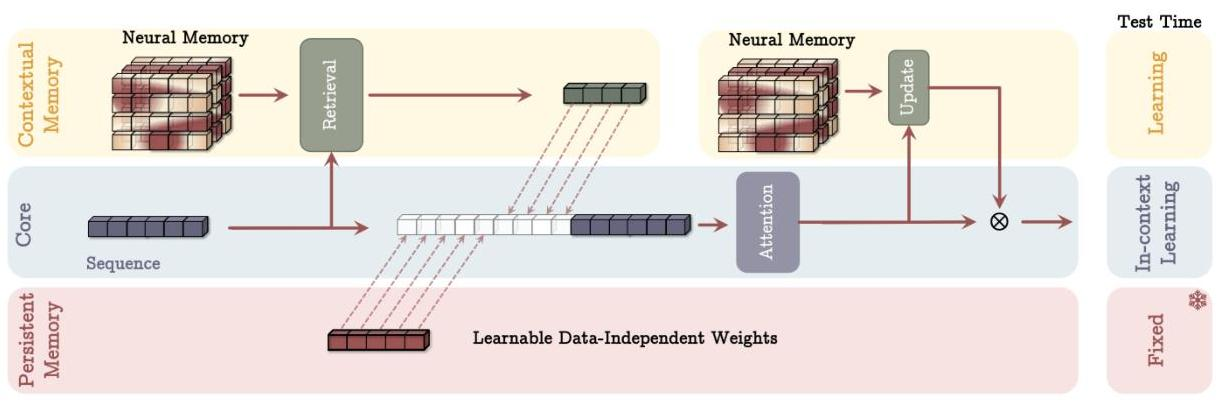

Figure 2: Memory as a Context (MAC) Architecture. This architecture includes three branches of (1) core, (2) contextual (long-term) memory, and (3) persistent memory. The core branch concatenates the corresponding long-term and persistent memories with the input sequence. Next, attention performs on the sequence and decides what part of the information should store in the long-term memory. At the test time, parameters corresponds to contextual memory are still learning, parameters corresponds to the core branch are responsible for in-context learning, and parameters of persistent memory are responsible to store the knowledge about tasks and so are fixed.

# 3.3 Persistent Memory 

Our long-term memory can also be seen as a contextual memory, meaning that the output is fully depend on the context. Therefore, in addition to our long-term memory, we also use a set of learnable but input-independent parameters to act as task-related memory. This type of memory has been referred to as persistent or meta-memory in the literature (X. Dong et al. 2024; Sukhbaatar, Grave, et al. 2019). Given $N_{p} \geq 1$, we use learnable parameters $P=\left[\begin{array}{llll}p_{1} & p_{2} & \ldots & p_{N_{p}}\end{array}\right]$ and append it to the start of our sequence: i.e., given a context window size of $N$, we modify the input as:

$$
x_{\text {new }}=\left[\begin{array}{llll}
p_{1} & p_{2} & \ldots & p_{N_{p}}
\end{array}\right] \| x
$$

where $\|$ is concatenation. Next, we discuss the motivation of persistent memory from three perspective:
Memory Perspective. As discussed earlier, our neural long-term memory is a contextual memory, in which all parameters are input-dependent. An effective memory system, however, also needs input-independent parameters to store the abstraction of the task knowledge. That is, mastering a task requires the memorization of the knowledge that how the task can be done, and these parameters are responsible for storing such knowledge.

Feedforward Network Perspective. In the Transformer architectures, there are fully connected layers after the attention module, which are shown to be similar to attention weights but with data-independent parameters. That is, Sukhbaatar, Grave, et al. (2019) showed that replacing the ReLU in fully connected layers with Softmax can results in an attention-like weights, in which weights are data-independent:

$$
F F N(x)=W_{V} \operatorname{Softmax}\left(W_{K} x\right)
$$

In fact, $W_{K}$ and $W_{V}$ are acting similar to $K$ and $V$ matrices in attention module when they are input-independent. The persistent memory weights are expected to have the same functionality, meaning that using them in the first part of the sequence leads to having input-independent attention weights (Sukhbaatar, Grave, et al. 2019).

Technical Perspective. Attention with causal mask has implicit bias toward initial tokens in the sequence, and so attention weights are almost always highly active for initial tokens, resulting in performance damage. From the technical perspective, these learnable parameters at the start of the sequence can mitigate such effect by redistributing the attention weights more effectively (Han et al. 2024; Xiao et al. 2024).

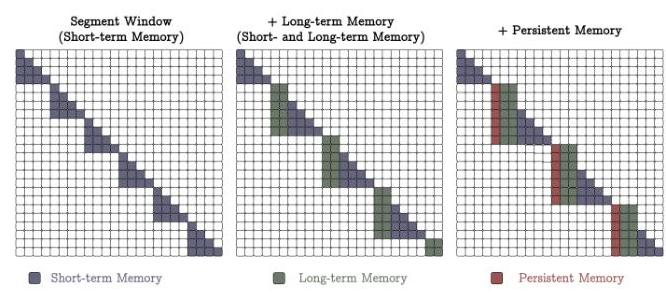
(a) Memory as a Context (MAC). We segment the sequence and use full causal attention in each window. Again, the first $N_{p}$ tokens are persistent memory and the next $N_{l}$ are long-term memory tokens
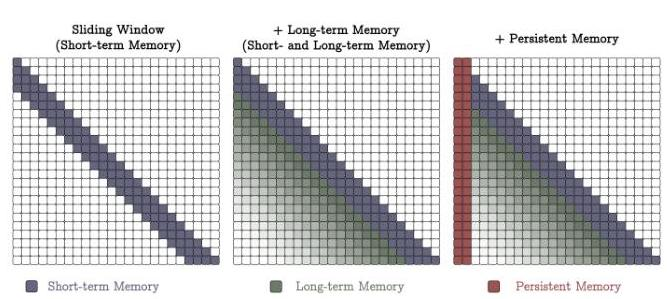
(b) Memory as Gating (MAG). We use sliding window attention (SWA) as a short-term memory and our neural memory module as a long-term memory, combining by a gating.

Figure 3: Attention masks for different variants of Titans.

# 4 How to Incorporate Memory? 

n important question that remained unanswered is: How one can effectively and efficiently incorporate the designed neural memory into a deep learning architecture? As discussed earlier, from a memory perspective, the pair of K and V matrices in transformers can be interpreted as an associative memory block. Due to their accurate modeling of dependencies and so their limited context window, we interpret them as short-term memory modules, attending to the current context window size. On the other hand, our neural memory with the ability to continuously learn from data and store it in its weights can play the role of a a long-term memory. In this section, we aim to answer the above question by proposing three different variants of Titans. Later in our experiments, we show that each of these variants has its own advantages/disadvantages and also can show a trade-off between the efficiency and effectiveness in very long-contexts.

### 4.1 Memory as a Context

In the first architecture design (see Figure 2), we treat the memory as a context to the current information. That is, given a long sequence $x \in \mathbb{R}^{N \times d_{\mathrm{m}}}$, we first chunk the sequence into fixed-size segments $\mathrm{S}^{(i)}$ for $i=1, \ldots, N / C$. Given the incoming segment $\mathrm{S}^{(t)}$, we consider it as the current context and its past segment as the historical information. Therefore, let $\mathcal{M}_{t-1}$ be the state of long-term memory before segment $\mathrm{S}^{(t)}$, we use the input context as the query to the memory $\mathcal{M}_{t-1}$ to retrieve the corresponding information from the long-term memory. That is, we retrieve the past information that corresponds to $\mathrm{S}^{(t)}$ as:

$$
h_{t}=\mathcal{M}_{t-1}^{*}\left(\mathbf{q}_{t}\right)
$$

where $\mathbf{q}_{t}=\mathrm{S}^{(t)} W_{Q}$. Next, we use this historical information along with our persistent memory parameters as the input sequence to the attention module:

$$
\begin{aligned}
& \dot{\mathrm{S}}^{(t)}=\left[\begin{array}{llllll}
p_{1} & p_{2} & \ldots & p_{N_{p}}
\end{array}\right]\left\|h_{t}\right\| \mathrm{S}^{(t)} \\
& y_{t}=\operatorname{Attn}\left(\dot{\mathrm{~S}}^{(t)}\right)
\end{aligned}
$$

The structure of the attention map over the entire sequence is shown in Figure 3a. We then use $y_{t}$ to update the long-term memory module for the next segment and the final output:

$$
\begin{aligned}
& \mathcal{M}_{t}=\mathcal{M}_{t-1}\left(y_{t}\right) \\
& o_{t}=y_{t} \otimes \mathcal{M}_{t}^{*}\left(y_{t}\right)
\end{aligned}
$$

Note that, in the above, we are updating the weight of $\mathcal{M}_{t-1}$ through forward pass.
This architecture has two key advantages: (1) Attention by having both historical and current context, has the ability to decides whether given the current data, the long-term memory information is needed. (2) The attention module helps

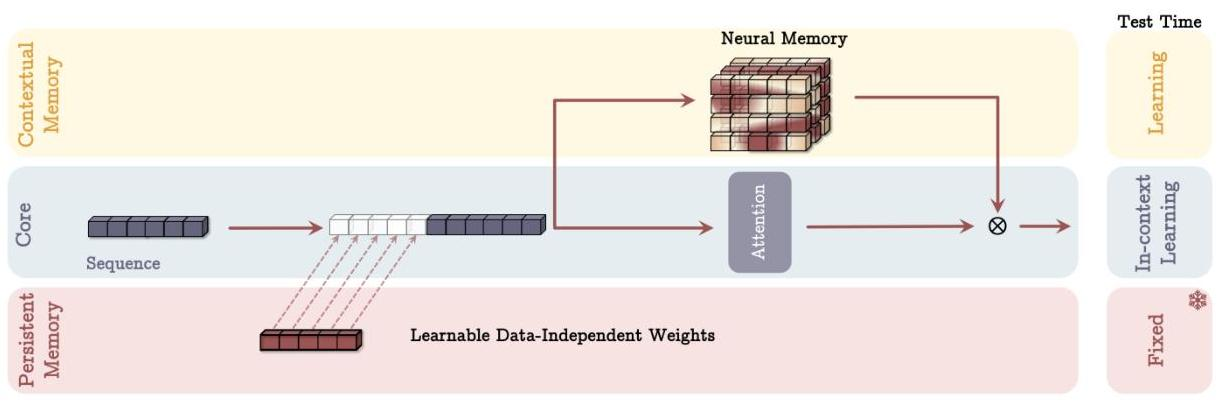

Figure 4: Memory as a Gate (MAG) Architecture. This architecture, similarly, has the three branches of (1) core, (2) contextual memory, and (3) persistent memory. It, however, incorporates only persistent memory into the context and combine memory with the core branch using a gating mechanism. At test time, the behavior is the same as Figure 2.
the long-term memory to store only useful information from the current context. That is, not all tokens in each segment are useful and memorizing all of them can result in memory overflow. Therefore, attention is helping the memory to understand which information is useful, better managing the memory capacity. (3) At test time: (i) persistent memory parameters are fixed as they encodes the knowledge about the task, which should not be changed; (ii) the attention module weights are in-context learner; and (iii) the long-term memory module is still learning (memorizing) the information at test time. That is, we update the weights of the neural memory even at test time as weights are encoding the abstraction of long past.

# 4.2 Gated Memory 

In the next variant (see Figure 4), in one branch, we directly use the input data to update the long-term memory, and in the second branch, we use a sliding window attention (SWA):

$$
\begin{aligned}
& \tilde{x}=\left[\begin{array}{llll}
p_{1} & p_{2} & \ldots & p_{N_{p}}
\end{array}\right] \| x \\
& y=\mathrm{SW}-\mathrm{Attn}^{*}(\tilde{x}) \\
& o=y \otimes \mathcal{M}(\tilde{x})
\end{aligned}
$$

where SW-Attn* is sliding window attention with prefix (see Figure 3b). Note that, contrary to the previous design, we are not segmenting the input data. Also, we abuse the notation and use $\mathcal{M}(x)$ to refer to the final output of the memory after all recursion over the tokens of the sequence. In the above equation, $\otimes$ can be any non-linear gating. In our experiments, we normalize the outputs $y$ and $\mathcal{M}(\tilde{x})$ using learnable vector-valued weights, followed by a non-linearity $\sigma($.$) .$

The overall attention mask of this design is shown in Figure 3b. In this design, sliding window attention is act as a precise short-term memory, while the neural memory module is acting as a fading memory for the model. This architecture design can also be seen as a multi-head architecture where the structure of heads are different (X. Dong et al. 2024).

### 4.3 Memory as a Layer

The last variant uses the neural Memory As a Layer (MAL) of a deep neural network (see Figure 5). This architecture design is more common in the literature, where the hybrid models stack recurrent models with full or sliding window attentions. Given input $x$, we have:

$$
\begin{aligned}
& \tilde{x}=\left[\begin{array}{llll}
p_{1} & p_{2} & \ldots & p_{N_{p}}
\end{array}\right] \| x \\
& y=\mathcal{M}(\tilde{x}) \\
& o=\mathrm{SW}-\operatorname{Attn}(y)
\end{aligned}
$$

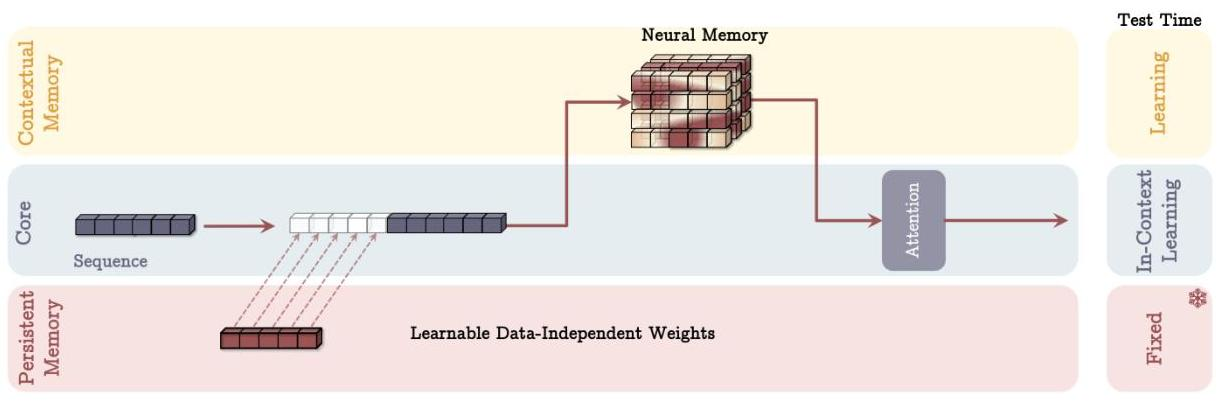

Figure 5: Memory as a Layer (MAL) Architecture. In this architecture, the memory layer is responsible to compress the past and current context before the attention module.
where SW-Attn is sliding window attention. The main drawback of this design is that the power of the model is limited by each of the layers and so it cannot take advantage of the complementary data processing of attention and neural memory module. In our experiments, for evaluating memory in this design, we use a similar architecture as H3 (D. Y. Fu et al. 2023), where we replace the the sequence model with our neural memory module (LMM).

Memory Without Attention. Although in the above, we discussed MAL as the combination of LMMs and attention in a sequential manner, one simple variant of MAL is to treat LMM as a sequence model without any attention. From the memory perspective, as discussed in Section 1, we expect each part of the memory system to work independently, even if other components are disturbed. Therefore, a long-term memory module should still be a powerful model even without short-term memory (i.e., attention). We refer to this variant as LMM or Titans (LMM) in our experiments. We provide additional discussions on the connection of Titans and other modern recurrent models in Appendix C.

# 4.4 Architectural Details 

For the sake of simplicity and presentation, we avoid discussing the implementation details like using residual connection, gating with linear layer, and normalization. In all blocks, we use residual connections. In our implementation, we use $\operatorname{SiLU}($.$) activation (Elfwing, Uchibe, and Doya 2018) as the non-linear activation for computing query, key, and values and normalize queries and keys using $\ell_{2}$-norm.

Convolution. Following the recent modern linear recurrent models (Gu and Dao 2024; S. Yang, Kautz, and Hatamizadeh 2024), we incorporate a 1D depthwise-separable convolution layer after each of the query, key, and value projections. While not significantly affect the performance, these 1D convolutions have shown performance improvement and are also computationally efficient.

Gating. We also follow the recent architectures that use normalization and gating with a linear layer before the final output projection (Mehta et al. 2023).

Theorem 4.1. Contrary to Transformers, diagonal linear recurrent models, and DeltaNet, all of which are limited to $\mathrm{TC}^{0}$ (Merrill, Petty, and Sabharwal 2024), Titans are capable of solving problems beyond $\mathrm{TC}^{0}$, meaning that Titans are theoretically more expressive than Transformers and most modern linear recurrent models in state tracking tasks.

## 5 Experiments

Next, we evaluate the performance of Titans and its variants in language modeling, commonsense reasoning, needle in haystack, DNA modeling, and time series forecasting tasks ${ }^{1}$. In more details, in this section, we answer the following empirical questions: (1) How do Titans perform compared to baselines in downstream tasks? (see §5.2,

[^0]
[^0]:    ${ }^{1}$ In the first version of the work, we aim to provide insights/evidences about why the learning paradigms of Titans are effective. We are working on finalizing the results of larger models and will report them in the next version.

§5.6, and §5.7); (2) What is the actual context length of Titans? (see $\S 5.3$ and $\S 5.4$ ); (3) How do Titans scale with respect to context length? (see §5.8); (4) How the depth of memory can affect both performance and efficiency? (see §5.5); and (5) What is the contribution of each Titans' component in its performance? (see §5.9).

# 5.1 Experimental Setup 

Models. In our experiments, we focus on the three variants of Titans, which we refer to as: Titans with (1) Memory as a Context (MAC), (2) Memory as a Gate (MAG), and (3) Memory as a Layer (MAL) as well as (4) neural memory module alone. The reason behind using our long-term memory as a separate module is based on our definition of learning. As discussed in Section 1, we define learning a process for acquiring effective and useful memory. Accordingly, we expect our long-term memory to effectively learn from data, even without attention. For each of these models, we consider four scales with: (i) 170 M , (ii) 340 M , (iii) 400 M , and (iv) 760 M parameters. While the first three are trained on 15B tokens sampled from FineWeb-Edu dataset (Penedo et al. 2024), the last one is trained on 30B tokens from the same dataset.

Baselines. We compare our models with the state-of-the-art linear recurrent models, Transformers, and hybrid models (recurrent + attention). More specifically in language tasks, we compare with Transformer++ (Touvron et al. 2023), RetNet (Yutao Sun et al. 2023), Gated Linear Attention (GLA) (S. Yang, B. Wang, Shen, et al. 2024), Mamba (Gu and Dao 2024), Mamba2 (Dao and Gu 2024), DeltaNet (S. Yang, B. Wang, Yu Zhang, et al. 2024), TTT (Yu Sun et al. 2024), and Gated DeltaNet (S. Yang, Kautz, and Hatamizadeh 2024). In needle in haystack tasks, we also compare with GPT4 (Achiam et al. 2023), Llama3 with RAG (Touvron et al. 2023), RecurrentGemma2-9B (Botev et al. 2024), and Mistral (Jiang et al. 2023) models, all of which are provided in the benchmark (Yuri Kuratov et al. 2024). In time series tasks, we compare with Mamba-based (Behrouz, Santacatterina, and Zabih 2024), Transformer-based (Y. Liu et al. 2023; Nie et al. 2022; Yunhao Zhang and Yan 2023), and linear models (Das et al. 2023; Z. Li et al. 2023; H. Wu et al. 2023; Zeng et al. 2023).

Training. In the training, we follow the training procedure of S. Yang, Kautz, and Hatamizadeh (2024), and use LLama 2 tokenizer with a vocabulary size of 32 K and use training length of 4 K tokens. We employ AdamW optimizer with learning rate of $4 \mathrm{e}-4$ with cosine annealing schedule with batch size of 0.5 M tokens, and weight decay of 0.1 .

### 5.2 Language Modeling

We first focus on the perplexity in language modeling and also commonsense reasoning tasks. The results for Titans' variants and also baselines with three different sizes of 340 M , 400 M , and 760 M are reported in Table 1. Among non-hybrid models, including Transformer++, our neural memory module achieves the best performance in both perplexity and accuracy measures. Comparing our neural memory module and TTT, which is also a gradient-based recurrent model can show us the importance of our weight decay as well as the momentum. As discussed earlier, the weight decay can be interpreted as a gating mechanism to forget the past data, when it is needed. Also, momentum can help us better manage the memory by providing additional memory for the surprise metric. While some baselines also take advantage of gating mechanism, e.g., Mamba, Mamba2, and Gated DeltaNet, the superior performance of our neural memory module shows the importance of both our surprise mechanism and having deep and non-linear memory. We further discuss the later in Section 5.5.

Comparing the hybrid models, we found that all three variants of Titans (MAC, MAG, and MAL) outperform both Samba (Mamba + attention) and Gated DeltaNet-H2 (Gated DeltaNet + atttention). We attribute the superior performance of Titans (MAL) to the power of neural memory module as the architecture design and used attention are all the same. Comparing Titans (MAG) and (MAC), we find that while their performance are close, MAC performs better when dealing with longer dependencies in the data. Interestingly, both MAG and MAC outperform MAL variant, which due to using the same modules, we attribute this to the architecture design of these models. This finding is particularly important as the current hybrid models (except Hymba (X. Dong et al. 2024)) in the literature are using MAL-style combination of recurrent models and attention.

### 5.3 Needle in a Haystack

Scaling a model to longer context window is not always equivalent to being effective for very long sequences (Hsieh et al. 2024). The needle-in-a-haystack (NIAH) task is designed to measure the actual effective context length of models. In this task, we evaluate the model on retrieving a piece of information (i.e., the "needle") from long distractor texts (i.e.,

Table 1: Performance of Titans and recurrent- and Transformer-based baselines on language modeling and common-sense reasoning tasks. Hybrid models are marked with *. The best results among simple and hybrid models are highlighted.

| Model | Wiki. <br> $\mathrm{ppl} \downarrow$ | LMB. <br> $\mathrm{ppl} \downarrow$ | LMB. <br> acc $\uparrow$ | PIQA acc $\uparrow$ | Hella. acc_n $\uparrow$ | Wino. acc $\uparrow$ | ARC-e acc $\uparrow$ | ARC-c acc_n $\uparrow$ | SIQA acc $\uparrow$ | BoolQ acc $\uparrow$ | Avg. $\uparrow$ |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| 340M params / 1SB tokens |  |  |  |  |  |  |  |  |  |  |  |
| Transformer++ | 31.52 | 41.08 | 30.76 | 62.98 | 34.76 | 50.53 | 45.21 | 24.05 | 36.81 | 58.24 | 42.92 |
| RetNet | 32.50 | 49.73 | 28.24 | 62.61 | 34.15 | 50.91 | 44.27 | 23.62 | 36.79 | 59.72 | 42.54 |
| GLA | 28.51 | 43.02 | 28.73 | 64.05 | 35.96 | 50.00 | 54.19 | 24.29 | 37.13 | 58.39 | 44.09 |
| Mamba | 30.83 | 40.21 | 29.94 | 63.79 | 35.88 | 49.82 | 49.24 | 24.56 | 35.41 | 60.07 | 43.59 |
| DeltaNet | 28.65 | 47.30 | 28.43 | 63.52 | 35.95 | 49.63 | 52.68 | 25.37 | 37.96 | 58.79 | 44.04 |
| TTT | 27.44 | 34.19 | 30.06 | 63.97 | 35.71 | 50.08 | 53.01 | 26.11 | 37.32 | 59.83 | 44.51 |
| Gated DeltaNet | 27.01 | 30.94 | 34.11 | 63.08 | 38.12 | 51.60 | 55.28 | 26.77 | 34.89 | 59.54 | 45.42 |
| Titans (LMM) | 26.18 | 29.97 | 34.98 | 64.73 | 39.61 | 51.85 | 55.60 | 28.14 | 34.52 | 59.99 | 46.17 |
| Titans (MAC)* | 25.43 | 28.13 | 36.00 | 65.32 | 40.35 | 51.21 | 58.17 | 29.00 | 38.63 | 60.18 | 47.36 |
| Titans (MAG)* | 25.07 | 28.72 | 36.71 | 64.88 | 40.56 | 52.49 | 57.72 | 28.16 | 39.75 | 60.01 | 47.54 |
| Titans (MAL)* | 24.69 | 28.80 | 35.74 | 64.97 | 39.44 | 51.97 | 56.58 | 28.21 | 38.14 | 57.32 | 46.55 |
| 400M params / 1SB tokens |  |  |  |  |  |  |  |  |  |  |  |
| Transformer++ | 30.63 | 37.37 | 29.64 | 64.27 | 37.72 | 51.53 | 54.95 | 27.36 | 38.07 | 61.59 | 45.64 |
| RetNet | 29.92 | 46.83 | 29.16 | 65.23 | 36.97 | 51.85 | 56.01 | 27.55 | 37.30 | 59.66 | 45.47 |
| HGRN2 | 32.33 | 47.14 | 26.12 | 64.52 | 35.45 | 52.24 | 55.97 | 25.51 | 37.35 | 59.02 | 44.52 |
| GLA | 27.96 | 36.66 | 27.86 | 65.94 | 37.41 | 49.56 | 56.01 | 26.36 | 38.94 | 59.84 | 45.24 |
| Mamba | 29.22 | 39.88 | 29.82 | 65.72 | 37.93 | 50.11 | 58.37 | 26.70 | 37.76 | 61.13 | 45.94 |
| Mamba2 | 26.34 | 33.19 | 32.03 | 65.77 | 39.73 | 52.48 | 59.00 | 27.64 | 37.92 | 60.72 | 46.91 |
| DeltaNet | 27.69 | 44.04 | 29.96 | 64.52 | 37.03 | 50.82 | 56.77 | 27.13 | 38.22 | 60.09 | 45.57 |
| TTT | 26.11 | 31.52 | 33.25 | 65.70 | 39.11 | 51.68 | 58.04 | 28.99 | 38.26 | 59.87 | 46.86 |
| Gated DeltaNet | 25.47 | 29.24 | 34.40 | 65.94 | 40.46 | 51.46 | 59.80 | 28.58 | 37.43 | 60.03 | 47.26 |
| Samba* | 25.32 | 29.47 | 36.86 | 66.09 | 39.24 | 51.45 | 60.12 | 27.20 | 38.68 | 58.22 | 47.23 |
| Gated DeltaNet-H2* | 24.19 | 28.09 | 36.77 | 66.43 | 40.79 | 52.17 | 59.55 | 29.09 | 39.04 | 58.56 | 47.69 |
| Titans (LMM) | 25.03 | 28.99 | 35.21 | 65.85 | 40.91 | 52.19 | 59.97 | 29.20 | 38.74 | 60.85 | 47.83 |
| Titans (MAC)* | 25.61 | 27.73 | 36.92 | 66.39 | 41.18 | 52.80 | 60.24 | 29.69 | 40.07 | 61.93 | 48.65 |
| Titans (MAG)* | 23.59 | 27.81 | 37.24 | 66.80 | 40.92 | 53.21 | 60.01 | 29.45 | 39.91 | 61.28 | 48.60 |
| Titans (MAL)* | 23.93 | 27.89 | 36.84 | 66.29 | 40.74 | 52.26 | 59.85 | 29.71 | 38.92 | 58.40 | 47.87 |
| 760M params / 30B tokens |  |  |  |  |  |  |  |  |  |  |  |
| Transformer++ | 25.21 | 27.64 | 35.78 | 66.92 | 42.19 | 51.95 | 60.38 | 32.46 | 39.51 | 60.37 | 48.69 |
| RetNet | 26.08 | 24.45 | 34.51 | 67.19 | 41.63 | 52.09 | 63.17 | 32.78 | 38.36 | 57.92 | 48.46 |
| Mamba | 28.12 | 23.96 | 32.80 | 66.04 | 39.15 | 52.38 | 61.49 | 30.34 | 37.96 | 57.62 | 47.22 |
| Mamba2 | 22.94 | 28.37 | 33.54 | 67.90 | 42.71 | 49.77 | 63.48 | 31.09 | 40.06 | 58.15 | 48.34 |
| DeltaNet | 24.37 | 24.60 | 37.06 | 66.93 | 41.98 | 50.65 | 64.87 | 31.39 | 39.88 | 59.02 | 48.97 |
| TTT | 24.17 | 23.51 | 34.74 | 67.25 | 43.92 | 50.99 | 64.53 | 33.81 | 40.16 | 59.58 | 47.32 |
| Gated DeltaNet | 21.18 | 22.09 | 35.54 | 68.01 | 44.95 | 50.73 | 66.87 | 33.09 | 39.21 | 59.14 | 49.69 |
| Samba* | 20.63 | 22.71 | 39.72 | 69.19 | 47.35 | 52.01 | 66.92 | 33.20 | 38.98 | 61.24 | 51.08 |
| Gated DeltaNet-H2* | 19.88 | 20.83 | 39.18 | 68.95 | 48.22 | 52.57 | 67.01 | 35.49 | 39.39 | 61.11 | 51.49 |
| Titans (LMM) | 20.04 | 21.96 | 37.40 | 69.28 | 48.46 | 52.27 | 66.31 | 35.84 | 40.13 | 62.76 | 51.56 |
| Titans (MAC) | 19.93 | 20.12 | 39.62 | 70.46 | 49.01 | 53.18 | 67.86 | 36.01 | 41.87 | 62.05 | 52.51 |
| Titans (MAG) | 18.61 | 19.86 | 40.98 | 70.25 | 48.94 | 52.89 | 68.23 | 36.19 | 40.38 | 62.11 | 52.50 |
| Titans (MAL) | 19.07 | 20.33 | 40.05 | 69.99 | 48.82 | 53.02 | 67.54 | 35.65 | 30.98 | 61.72 | 50.97 |

the "haystack"). In this part, we use Single NIAH (S-NIAH) task from RULER benchmark (Hsieh et al. 2024) and evaluate Titans and baselines on sequences with length $2 \mathrm{~K}, 4 \mathrm{~K}, 8 \mathrm{~K}$, and 16 K . The results are reported in Table 2. Neural Memory module achieves the best results compare to baselines in all three tasks. We attribute this superior performance to three key differences of Titans with existing sequence models: (1) Compared to TTT, our Neural Memory can better handle the memory capacity by using momentum and also the forgetting mechanism (i.e., weight decay). Therefore, with increasing the sequence length, the performance of Neural Memory does not drop and show a consistent trend; (2) Compared to Mamba2, which has the gating (forgetting) mechanism, Titans have deep non-linear memory, resulting in better memory management. Also, contrary to our neural memory and DeltaNet, Mamba2 is not capable of removing a memory and so

Table 2: Performance of Titans and baselines on S-NIAH task from RULER benchmark. The best results among simple and hybrid models are highlighted.

| Model | S-NIAH-PK |  |  |  | S-NIAH-N |  |  |  | S-NIAH-W |  |  |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  | 2K | 4K | 8K | 16K | 2K | 4K | 8K | 16K | 2K | 4K | 8K | 16K |
| TTT | 98.4 | 98.8 | 98.0 | 88.4 | 60.2 | 36.6 | 10.2 | 4.4 | 78.8 | 28.0 | 4.4 | 0.0 |
| Mamba2 | 98.6 | 61.4 | 31.0 | 5.4 | 98.4 | 55.8 | 14.2 | 0.0 | 42.2 | 4.2 | 0.0 | 0.0 |
| DeltaNet | 96.8 | 98.8 | 98.6 | 71.4 | 47.2 | 15.4 | 12.8 | 5.4 | 46.2 | 20.0 | 1.6 | 0.0 |
| Titans (LMM) | 99.8 | 98.4 | 98.2 | 96.2 | 100.0 | 99.8 | 93.4 | 80.2 | 90.4 | 89.4 | 85.8 | 80.6 |
| Titans (MAC) | 99.2 | 98.8 | 99.0 | 98.4 | 99.6 | 98.2 | 97.6 | 97.4 | 98.2 | 98.2 | 95.6 | 95.2 |
| Titans (MAG) | 99.4 | 98.0 | 97.4 | 97.4 | 99.2 | 98.8 | 97.2 | 98.6 | 98.0 | 98.0 | 90.2 | 88.2 |
| Titans (MAL) | 98.8 | 98.6 | 98.8 | 97.8 | 99.8 | 98.1 | 96.8 | 96.4 | 98.0 | 97.4 | 92.0 | 90.4 |

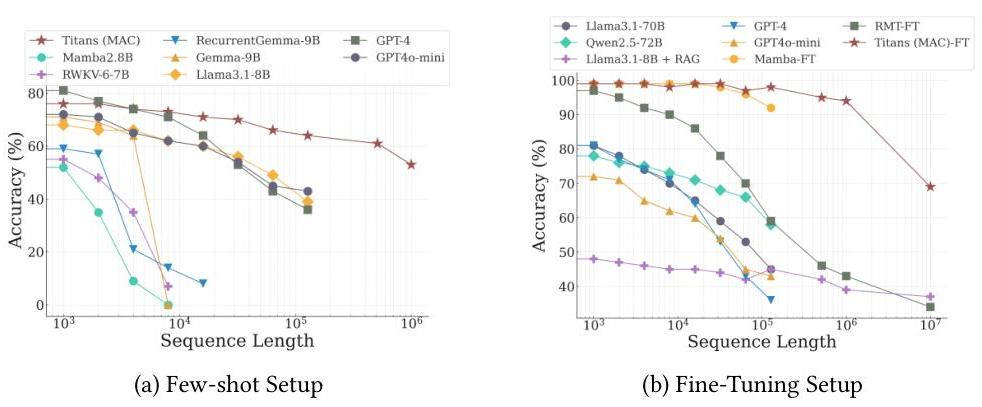

Figure 6: Performance of Titans and baselines on BABILong benchmark. Titans (MAC) outperforms all baselines, including extremely large models, e.g., GPT4.
we can see a significant drop in performance when increasing the sequence length; (3) Compared to DeltaNet, although it is capable of removing memory using delta rule, it cannot erase the memory, lacking forgetting mechanism. Finally, As expected we can see on par or better results when using Titans variants, where the best results correspond to MAC.

# 5.4 BABILong Benchmark 

In the previous section we discussed the results on a simple NIAH tasks where a single needle needs to be retrieved. Although Titans showed better performance compared to baselines, their true advantage over very long sequences is still hidden. To this end, in this section, we use a harder task from BABILong benchmark (Yuri Kuratov et al. 2024), in which the model needs to reason across facts distributed in extremely long documents. We follow the original experimental setup and training process in the benchmark. There are two settings: (1) Few-shot setting, in which we use large pre-trained models, and (2) fine-tuning setting, where we fine-tune the MAC variant of Titans to compare it with other fine-tuned baselines. The results for few-shot setting are reported in Figure 6a. In this setup, we can see Titans outperform all baselines-i.e., Mamba2.8B (Gu and Dao 2024), RWKV-6-7B (Peng, Goldstein, et al. 2024), RecurrentGemma-9B (Botev et al. 2024), Gemma-9B (Team et al. 2024), Llama3.1-8B (Touvron et al. 2023), GPT-4, and GPT4o-mini (Achiam et al. 2023). These results are achieved while Titans (MAC) is having much less number of parameters than baselines.

In the fine-tuning setup, we compare the small fine-tuned version of Titans (MAC) with: (i) the fine-tuned version of small models (almost the same number of parameters as Titans) such as Mamba (Gu and Dao 2024), RMT (Bulatov, Yury Kuratov, and Burtsev 2022), (ii) large models with Retrieval-Augmented Generation (RAG) (P. Lewis et al. 2020) such as Llama3.18B (Touvron et al. 2023), and (iii) extremely large models such as GPT-4 (Achiam et al. 2023), GPT4o-mini, Qwen2.5-72B (A. Yang et al. 2024), and Llama3.1-70B (Touvron et al. 2023). Baseline results are reported by (Yuri Kuratov et al. 2024). The results of Titans and baselines are reported in Figure 6b. Titans outperform all models even extremely large models like GPT4. Also, compared to Transformer-based with memory models like RMT, Titans show better performance mainly due to their powerful memory. That is, RMT compress the historical data into 16 size vector-valued memory, while Titans with in-context online memory learner are capable of encoding the past into the parameters of the model. Interestingly, even

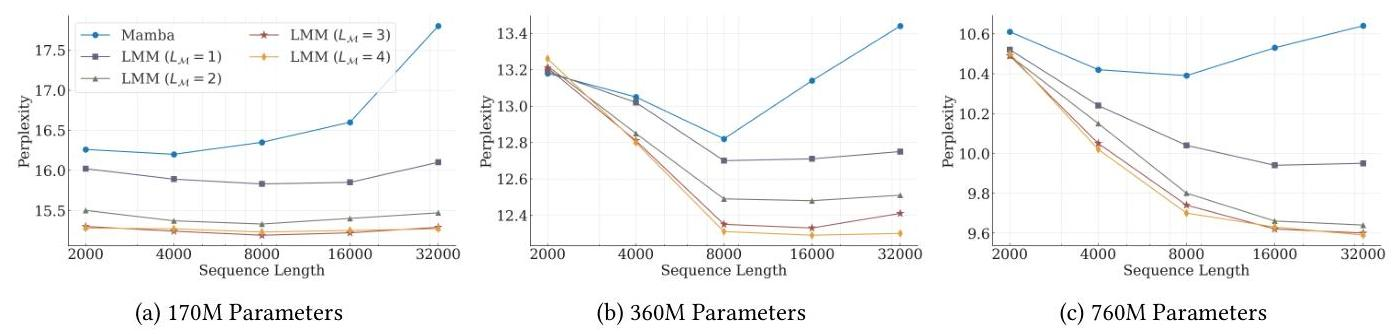

Figure 7: The effect of memory depth on the perplexity. Deeper long-term memory results in better scaling in longer sequences.

Table 3: Performance on long-term forecasting. The best results are highlighted.

|  | Neural Memory |  | Simba |  | iTranoformer |  | RLinear |  | PatchTST |  | Crossformer |  | TiDE |  | TimesNet |  | DLinear |  |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
|  | MSE | MAE | MSE | MAE | MSE | MAE | MSE | MAE | MSE | MAE | MSE | MAE | MSE | MAE | MSE | MAE | MSE | MAE |
| ETTm1 | 0.358 | 0.387 | 0.383 | 0.396 | 0.407 | 0.410 | 0.414 | 0.407 | 0.387 | 0.400 | 0.513 | 0.496 | 0.419 | 0.419 | 0.400 | 0.406 | 0.403 | 0.407 |
| ETTm2 | 0.261 | 0.309 | 0.271 | 0.327 | 0.288 | 0.332 | 0.286 | 0.327 | 0.281 | 0.326 | 0.757 | 0.610 | 0.358 | 0.404 | 0.291 | 0.333 | 0.350 | 0.401 |
| ETTh1 | 0.420 | 0.421 | 0.441 | 0.432 | 0.434 | 0.447 | 0.446 | 0.434 | 0.469 | 0.454 | 0.529 | 0.522 | 0.541 | 0.507 | 0.458 | 0.450 | 0.456 | 0.452 |
| ETTh2 | 0.336 | 0.382 | 0.361 | 0.391 | 0.383 | 0.407 | 0.374 | 0.398 | 0.387 | 0.407 | 0.942 | 0.684 | 0.611 | 0.550 | 0.414 | 0.427 | 0.559 | 0.515 |
| ECL | 0.162 | 0.261 | 0.169 | 0.274 | 0.178 | 0.270 | 0.219 | 0.298 | 0.205 | 0.290 | 0.244 | 0.334 | 0.251 | 0.344 | 0.192 | 0.295 | 0.212 | 0.300 |
| Traffic | 0.415 | 0.289 | 0.493 | 0.291 | 0.428 | 0.282 | 0.626 | 0.378 | 0.481 | 0.304 | 0.550 | 0.504 | 0.760 | 0.473 | 0.620 | 0.336 | 0.625 | 0.583 |
| Weather | 0.231 | 0.265 | 0.255 | 0.280 | 0.258 | 0.278 | 0.272 | 0.291 | 0.259 | 0.281 | 0.259 | 0.315 | 0.271 | 0.320 | 0.259 | 0.287 | 0.265 | 0.317 |

augmenting Llama3.1-8B model with RAG performs worse than Titans with about $\times 70$ less parameters.

# 5.5 The Effect of Deep Memory 

In this section, we evaluate the effect of deep memory in both wall-clock training time and model performance ${ }^{2}$. To this end, we focus on different variants of our neural memory module, where $L_{M}=1,2,3,4$. We also use Mamba as a baseline for the model performance. For a fair comparison, we use the same training process for all models and train them on a subset of the Pile dataset (L. Gao et al. 2020).

We report the perplexity of our models and baselines as the function of the sequence length in Figure 7. Interestingly, with the increase of memory depth, $L_{M}$, the model can achieve better perplexity over all sequence length. Also, deeper memory modules are more robust to the sequence length when the model has less number of parameters. With the increase of the number of parameters, all models show better performance on longer sequences.

We also evaluate the effect of memory depth $\left(L_{M}=1,2,3,4\right)$ on the training throughput. We report the training throughput (the number of tokens per second) as the function of sequence length in Figure 8. All models scale linearly with respect to the context length (i.e., constant trend in the number of tokens per second with respect to sequence length). Also, by increasing the memory depth, as expected, we can see a linear trend that a deeper memory results in a slower training. Therefore, it is not always efficient to use deeper memory modules, showing a trade-off between effectiveness and efficiency.

### 5.6 Time Series Forecasting

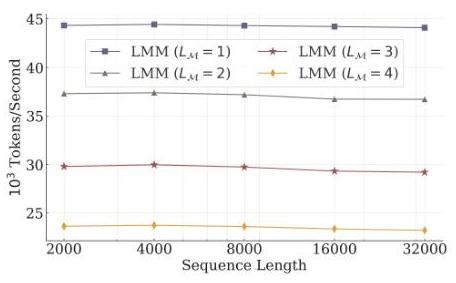

Figure 8: The effect of memory depth on training throughput

To show the effectiveness of our memory module in a broader tasks, we also evaluate its performance in time series forecasting tasks. To this end, we use Simba framework (Patro and Agneeswaran 2024) for time series forecasting, and

[^0]
[^0]:    ${ }^{2}$ Note that, in this experiment, we only focus on the neural memory module to evaluate the effect of memory depth in the memorization process. Combining neural memory with attention as we do in Titans variants, can additionally enhance the performance of the model over long sequences.

Table 4: Downstream evaluation of pre-trained DNA models on GenomicsBenchmarks (Grešová et al. 2023). We report top-1 classification accuracy (\%).

| Model | Enhancer Cohn | Enhancer Ens | Human Reg. | Non-TATA Promoters | Human OCR Ens. |
| :-- | :--: | :--: | :--: | :--: | :--: |
| CNN | 69.5 | 68.9 | 93.3 | 84.6 | 68.0 |
| DNABERT | 74.0 | 85.7 | 88.1 | 85.6 | 75.1 |
| GPT | 70.5 | 83.5 | 91.5 | 87.7 | 73.0 |
| HyenaDNA | 74.2 | 89.2 | 93.8 | 96.6 | 80.9 |
| Transformer++ | 73.4 | 89.5 | 89.9 | 94.4 | 79.5 |
| Mamba | 73.0 | - | - | 96.6 | - |
| Based | 74.6 | 89.5 | 89.5 | 96.8 | 79.0 |
| Neural Memory Module | 75.2 | 89.6 | 89.3 | 96.6 | 79.9 |

replace its Mamba module with our neural memory. We report the results on common time series forecasting benchmark datasets-ETT, ECL, Traffic, and Weather (H. Zhou et al. 2021). The results are reported in Table 3. Our neural memory module is outperforming all baselines, including Mamba-based, linear-based, and Transformer-based architectures.

# 5.7 DNA Modeling 

In order to understand the capability of Titans beyond natural language, we further evaluate the performance of our neural memory module on DNA modeling tasks. To this end, we evaluate pre-trained models on the downstream tasks in GenomicsBenchmarks (Grešová et al. 2023). We follow the same experimental setups from Nguyen et al. (2024), and re-use the reported results of baselines by Arora et al. (2024). The performance of Titans (LMM) and baselines are reported in Table 4. We find that LMM is competitive with state-of-the-art architectures across different downstream genomics tasks.

### 5.8 Efficiency

In this part, we compare the efficiency of our neural memory as well as Titans with state-of-the-art sequence models. The training throughput of models for different sequence length $\times$ batch size are reported in Figure 9. Comparing recurrent models, including our neural memory module, we can see our memory module is slightly slower than Mamba2 and Gated DeltaNet, mainly due to: (1) having deep memory and more expressive transition process (memory update), and (2) highly optimized kernel in the implementation of Mamba2. Interestingly, Titans (MAL) are faster than baselines as well as the memory module. The main reason for this better throughput is the highly optimized kernel of FlashAttention (Dao 2024), which is used for implementing SWA and full attention module in Titans.

### 5.9 Ablation Study

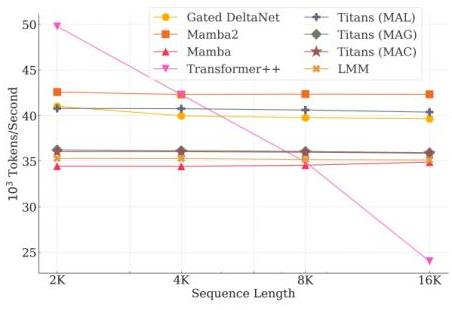

Figure 9: Training throughput comparison of Titans and baselines.

Finally, we perform ablation studies on the different architectural choices in Titans. We consider our neural memory module as a base model and then changing one component at a time: (1) replacing deep memory with linear memory, removing (2) convolution, (3) momentum in the surprise measure, (4) weight decay (or forgot mechanism), and (5) persistent memory. The results are reported in Table 5. All components of neural memory design are positively contributing to its performance, where the greatest contribution comes from weight decay, momentum, convolution, and persistent memory, respectively.

The Effect of Architectural Design. To evaluate the effect of architecture design, we compare the performance of three represented variants of Titans in three aspects of (i) language modeling, (ii) commen-sense reasoning, and (iii) long context NIAH (BABILong) tasks. The results are reported in Table 5. We find that MAC and MAG have close performance in language modeling and common-sense reasoning tasks, while MAC achieve significantly better performance in long-context NIAH. Both of these models achieve better performance than MAL. These results along with Figure 9, show a trade-off between fast training and more expressive design.

Table 5: Ablation Study on Titans. All components of Titans are positively contributing to its performance.

| Model | Language Modeling <br> ppl $\downarrow$ | Reasoning <br> acc $\uparrow$ | Long Context <br> acc $\uparrow$ |
| :-- | :--: | :--: | :--: |
| LMM | 27.01 | 47.83 | 92.68 |
| +Attn (MAC) | 26.67 | 48.65 | 97.95 |
| +Attn (MAG) | 25.70 | 48.60 | 96.70 |
| +Attn (MAL) | 25.91 | 47.87 | 96.91 |
| Linear Memory | 28.49 | 46.97 | 85.34 |
| w/o Convolution | 28.73 | 45.82 | 90.28 |
| w/o Momentum | 28.98 | 45.49 | 87.12 |
| w/o Weight Decay | 29.04 | 45.11 | 85.60 |
| w/o Persistent Memory | 27.63 | 46.35 | 92.49 |

# 6 Conclusion 

In this paper, we present a neural long-term memory that, as a meta in-context learner, learns to memorize at test time. The neural memory module is a recurrent model in nature, and is adaptively memorizing tokens that are more surprising or are close to surprising tokens. Comparing to modern recurrent models, it has more expressive memory update and storing mechanism. Using this memory, we present Titans architectures, and its three variants, in which we suggest to incorporate the memory module as (1) a context, (2) gating, and (3) a layer. Our experimental evaluation on diverse tasks tasks validate that Titans are more effective than Transformers and recent modern linear recurrent models, specifically for long context. That is, Titans can scale to larger than 2 M context window size with better accuracy than baselines.

Titans are implemented in Pytorch and JAX and we intend to make the code we used to train and evaluate our models available soon.

# References 

[1] Josh Achiam, Steven Adler, Sandhini Agarwal, Lama Ahmad, Ilge Akkaya, Florencia Leoni Aleman, Diogo Almeida, Janko Altenschmidt, Sam Altman, Shyamal Anadkat, et al. "Gpt-4 technical report". In: arXiv preprint arXiv:2303.08774 (2023).
[2] Yaroslav Aksenov, Nikita Balagansky, Sofia Maria Lo Cicero Vaina, Boris Shaposhnikov, Alexey Gorbatovski, and Daniil Gavrilov. "Linear Transformers with Learnable Kernel Functions are Better In-Context Models". In: arXiv preprint arXiv:2402.10644 (2024).
[3] Marcin Andrychowicz, Misha Denil, Sergio Gomez, Matthew W Hoffman, David Pfau, Tom Schaul, Brendan Shillingford, and Nando De Freitas. "Learning to learn by gradient descent by gradient descent". In: Advances in neural information processing systems 29 (2016).
[4] Cem Anil, Yuhuai Wu, Anders Andreassen, Aitor Lewkowycz, Vedant Misra, Vinay Ramasesh, Ambrose Slone, Guy Gur-Ari, Ethan Dyer, and Behnam Neyshabur. "Exploring length generalization in large language models". In: Advances in Neural Information Processing Systems 35 (2022), pp. 38546-38556.
[5] Simran Arora, Sabri Eyuboglu, Michael Zhang, Aman Timalsina, Silas Alberti, James Zou, Atri Rudra, and Christopher Re. "Simple linear attention language models balance the recall-throughput tradeoff". In: Forty-first International Conference on Machine Learning. 2024. URL: https://openreview.net/forum?id=e93ffDcpH3.
[6] Dzmitry Bahdanau. "Neural machine translation by jointly learning to align and translate". In: arXiv preprint arXiv:1409.0473 (2014).
[7] Reza Bayat, Mohammad Pezeshki, Elvis Dohmatob, David Lopez-Paz, and Pascal Vincent. "The Pitfalls of Memorization: When Memorization Hurts Generalization". In: arXiv preprint arXiv:2412.07684 (2024).
[8] Maximilian Beck, Korbinian Pöppel, Markus Spanring, Andreas Auer, Oleksandra Prudnikova, Michael Kopp, Günter Klambauer, Johannes Brandstetter, and Sepp Hochreiter. "xLSTM: Extended Long Short-Term Memory". In: arXiv preprint arXiv:2405.04517 (2024).
[9] Ali Behrouz, Michele Santacatterina, and Ramin Zabih. "Mambamixer: Efficient selective state space models with dual token and channel selection". In: arXiv preprint arXiv:2403.19888 (2024).
[10] Vincent-Pierre Berges, Barlas Oğuz, Daniel Haziza, Wen-tau Yih, Luke Zettlemoyer, and Gargi Gosh. "Memory Layers at Scale". In: arXiv preprint arXiv:2412.09764 (2024).
[11] Alberto Bietti, Vivien Cabannes, Diane Bouchacourt, Herve Jegou, and Leon Bottou. "Birth of a transformer: A memory viewpoint". In: Advances in Neural Information Processing Systems 36 (2024).
[12] Yonatan Bisk, Rowan Zellers, Jianfeng Gao, Yejin Choi, et al. "Piqa: Reasoning about physical commonsense in natural language". In: Proceedings of the AAAI conference on artificial intelligence. Vol. 34. 05. 2020, pp. 7432-7439.
[13] Aleksandar Botev, Soham De, Samuel L Smith, Anushan Fernando, George-Cristian Muraru, Ruba Haroun, Leonard Berrada, Razvan Pascanu, Pier Giuseppe Sessa, Robert Dadashi, et al. "RecurrentGemma: Moving Past Transformers for Efficient Open Language Models". In: arXiv preprint arXiv:2404.07839 (2024).
[14] Léon Bottou and Vladimir Vapnik. "Local learning algorithms". In: Neural computation 4.6 (1992), pp. 888-900.
[15] Aydar Bulatov, Yuri Kuratov, Yermek Kapushev, and Mikhail S Burtsev. "Scaling transformer to 1 m tokens and beyond with rmt". In: arXiv preprint arXiv:2304.11062 (2023).
[16] Aydar Bulatov, Yury Kuratov, and Mikhail Burtsev. "Recurrent memory transformer". In: Advances in Neural Information Processing Systems 35 (2022), pp. 11079-11091.
[17] Edoardo Cetin, Qi Sun, Tianyu Zhao, and Yujin Tang. "An Evolved Universal Transformer Memory". In: arXiv preprint arXiv:2410.13166 (2024).
[18] Beidi Chen, Tri Dao, Eric Winsor, Zhao Song, Atri Rudra, and Christopher Ré. "Scatterbrain: Unifying sparse and low-rank attention". In: Advances in Neural Information Processing Systems 34 (2021), pp. 17413-17426.
[19] Krzysztof Marcin Choromanski, Valerii Likhosherstov, David Dohan, Xingyou Song, Andreea Gane, Tamas Sarlos, Peter Hawkins, Jared Quincy Davis, Afroz Mohiuddin, Lukasz Kaiser, David Benjamin Belanger, Lucy J Colwell, and Adrian Weller. "Rethinking Attention with Performers". In: International Conference on Learning Representations. 2021. URL: https://openreview.net/forum?id=Ua6zuk0WRH.
[20] Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, and Kristina Toutanova. "BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions". In: Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers). Ed. by Jill Burstein, Christy Doran, and Thamar Solorio. Minneapolis, Minnesota: Association for Computational Linguistics, June 2019, pp. 2924-2936. DOI: 10.18653/v1/N19-1300. URL: https: //aclanthology.org/N19-1300/.

[21] Peter Clark, Isaac Cowhey, Oren Etzioni, Tushar Khot, Ashish Sabharwal, Carissa Schoenick, and Oyvind Tafjord. "Think you have solved question answering? try arc, the ai2 reasoning challenge". In: arXiv preprint arXiv:1803.05457 (2018).
[22] Nelson Cowan. "What are the differences between long-term, short-term, and working memory?" In: Progress in brain research 169 (2008), pp. 323-338.
[23] Zihang Dai, Zhilin Yang, Yiming Yang, Jaime G. Carbonell, Quoc Viet Le, and Ruslan Salakhutdinov. "TransformerXL: Attentive Language Models beyond a Fixed-Length Context". In: ACL (1). Ed. by Anna Korhonen, David R. Traum, and Lluís Márquez. Association for Computational Linguistics, 2019, pp. 2978-2988. ISBN: 978-1-950737-48-2.
[24] Tri Dao. "FlashAttention-2: Faster Attention with Better Parallelism and Work Partitioning". In: The Twelfth International Conference on Learning Representations. 2024. URL: https://openreview.net/forum?id=mZn2Xyh9Ec.
[25] Tri Dao, Dan Fu, Stefano Ermon, Atri Rudra, and Christopher Ré. "FlashAttention: Fast and Memory-Efficient Exact Attention with IO-Awareness". In: Advances in Neural Information Processing Systems. Ed. by S. Koyejo, S. Mohamed, A. Agarwal, D. Belgrave, K. Cho, and A. Oh. Vol. 35. Curran Associates, Inc., 2022, pp. 16344-16359. URL: https://proceedings.neurips.cc/paper_files/paper/2022/file/67d57c32e20fd0a7a302cb81d36e40d5-Paper-Conference.pdf.
[26] Tri Dao and Albert Gu. "Transformers are SSMs: Generalized models and efficient algorithms through structured state space duality". In: arXiv preprint arXiv:2405.21060 (2024).
[27] Abhimanyu Das, Weihao Kong, Andrew Leach, Shaan K Mathur, Rajat Sen, and Rose Yu. "Long-term Forecasting with TiDE: Time-series Dense Encoder". In: Transactions on Machine Learning Research (2023). ISSN: 2835-8856. URL: https://openreview.net/forum?id=pCbC3aQ85W.
[28] Soham De, Samuel L Smith, Anushan Fernando, Aleksandar Botev, George Cristian-Muraru, Albert Gu, Ruba Haroun, Leonard Berrada, Yutian Chen, Srivatsan Srinivasan, et al. "Griffin: Mixing gated linear recurrences with local attention for efficient language models". In: arXiv preprint arXiv:2402.19427 (2024).
[29] Juechu Dong, Boyuan Feng, Driss Guessous, Yanbo Liang, and Horace He. "Flex Attention: A Programming Model for Generating Optimized Attention Kernels". In: arXiv preprint arXiv:2412.05496 (2024).
[30] Xin Dong, Yonggan Fu, Shizhe Diao, Wonmin Byeon, Zijia Chen, Ameya Sunil Mahabaleshwarkar, Shih-Yang Liu, Matthijs Van Keirsbilck, Min-Hung Chen, Yoshi Suhara, et al. "Hymba: A Hybrid-head Architecture for Small Language Models". In: arXiv preprint arXiv:2411.13676 (2024).
[31] Stefan Elfwing, Eiji Uchibe, and Kenji Doya. "Sigmoid-weighted linear units for neural network function approximation in reinforcement learning". In: Neural networks 107 (2018), pp. 3-11.
[32] Yukun Feng, Feng Li, Ziang Song, Boyuan Zheng, and Philipp Koehn. "Learn to remember: Transformer with recurrent memory for document-level machine translation". In: arXiv preprint arXiv:2205.01546 (2022).
[33] Daniel Y Fu, Tri Dao, Khaled Kamal Saab, Armin W Thomas, Atri Rudra, and Christopher Re. "Hungry Hungry Hippos: Towards Language Modeling with State Space Models". In: The Eleventh International Conference on Learning Representations. 2023. URL: https://openreview.net/forum?id=COZDy0WYGg.
[34] Yossi Gandelsman, Yu Sun, Xinlei Chen, and Alexei Efros. "Test-time training with masked autoencoders". In: Advances in Neural Information Processing Systems 35 (2022), pp. 29374-29385.
[35] Leo Gao, Stella Biderman, Sid Black, Laurence Golding, Travis Hoppe, Charles Foster, Jason Phang, Horace He, Anish Thite, Noa Nabeshima, et al. "The pile: An 800gb dataset of diverse text for language modeling". In: arXiv preprint arXiv:2101.00027 (2020).
[36] Felix A Gers, Jürgen Schmidhuber, and Fred Cummins. "Learning to forget: Continual prediction with LSTM". In: Neural computation 12.10 (2000), pp. 2451-2471.
[37] Alex Graves, Greg Wayne, and Ivo Danihelka. Neural Turing Machines. 2014. arXiv: 1410.5401 [cs.NE]. URL: https://arxiv.org/abs/1410.5401.
[38] Klaus Greff, Rupesh K Srivastava, Jan Koutník, Bas R Steunebrink, and Jürgen Schmidhuber. "LSTM: A search space odyssey". In: IEEE transactions on neural networks and learning systems 28.10 (2016), pp. 2222-2232.
[39] Katarína Grešová, Vlastimil Martinek, David Čechák, Petr Šimeček, and Panagiotis Alexiou. "Genomic benchmarks: a collection of datasets for genomic sequence classification". In: BMC Genomic Data 24.1 (2023), p. 25.
[40] Albert Gu and Tri Dao. "Mamba: Linear-Time Sequence Modeling with Selective State Spaces". In: First Conference on Language Modeling. 2024. URL: https://openreview.net/forum?id=tEYskw1VY2.
[41] Albert Gu, Karan Goel, and Christopher Re. "Efficiently Modeling Long Sequences with Structured State Spaces". In: International Conference on Learning Representations. 2022. URL: https://openreview.net/forum?id= uYLFoz1vlAC.

[42] Chi Han, Qifan Wang, Hao Peng, Wenhan Xiong, Yu Chen, Heng Ji, and Sinong Wang. "LM-Infinite: Zero-Shot Extreme Length Generalization for Large Language Models". In: Proceedings of the 2024 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies (Volume 1: Long Papers). Ed. by Kevin Duh, Helena Gomez, and Steven Bethard. Mexico City, Mexico: Association for Computational Linguistics, June 2024, pp. 3991-4008. DOI: 10.18653/v1/2024. naacl-long.222. URL: https://aclanthology. org/2024. naacl-long. 222.
[43] Ramin Hasani, Mathias Lechner, Tsun-Hsuan Wang, Makram Chahine, Alexander Amini, and Daniela Rus. "Liquid Structural State-Space Models". In: The Eleventh International Conference on Learning Representations. 2023. URL: https://openreview.net/forum?id=g4OTKRKf57R.
[44] Zexue He, Leonid Karlinsky, Donghyun Kim, Julian McAuley, Dmitry Krotov, and Rogerio Feris. "CAMELoT: Towards Large Language Models with Training-Free Consolidated Associative Memory". In: arXiv preprint arXiv:2402.13449 (2024).
[45] Donald Olding Hebb. The organization of behavior: A neuropsychological theory. Psychology press, 2005.
[46] John J Hopfield. "Neural networks and physical systems with emergent collective computational abilities." In: Proceedings of the national academy of sciences 79.8 (1982), pp. 2554-2558.
[47] Kurt Hornik, Maxwell Stinchcombe, and Halbert White. "Multilayer feedforward networks are universal approximators". In: Neural networks 2.5 (1989), pp. 359-366.
[48] Cheng-Ping Hsieh, Simeng Sun, Samuel Kriman, Shantanu Acharya, Dima Rekesh, Fei Jia, and Boris Ginsburg. "RULER: What's the Real Context Size of Your Long-Context Language Models?" In: First Conference on Language Modeling. 2024. URL: https://openreview.net/forum?id=kIo8bc765y.
[49] DeLesley Hutchins, Imanol Schlag, Yuhuai Wu, Ethan Dyer, and Behnam Neyshabur. "Block-recurrent transformers". In: Advances in neural information processing systems 35 (2022), pp. 33248-33261.
[50] Kazuki Irie, Róbert Csordás, and Jürgen Schmidhuber. "The dual form of neural networks revisited: Connecting test time predictions to training patterns via spotlights of attention". In: International Conference on Machine Learning. PMLR. 2022, pp. 9639-9659.
[51] Kazuki Irie, Imanol Schlag, Róbert Csordás, and Jürgen Schmidhuber. "Going beyond linear transformers with recurrent fast weight programmers". In: Advances in neural information processing systems 34 (2021), pp. 7703-7717.
[52] Vidit Jain and Erik Learned-Miller. "Online domain adaptation of a pre-trained cascade of classifiers". In: CVPR 2011. IEEE. 2011, pp. 577-584.
[53] Albert Q Jiang, Alexandre Sablayrolles, Arthur Mensch, Chris Bamford, Devendra Singh Chaplot, Diego de las Casas, Florian Bressand, Gianna Lengyel, Guillaume Lample, Lucile Saulnier, et al. "Mistral 7B". In: arXiv preprint arXiv:2310.06825 (2023).
[54] Praneeth Kacham, Vahab Mirrokni, and Peilin Zhong. "PolySketchFormer: Fast Transformers via Sketching Polynomial Kernels". In: Forty-first International Conference on Machine Learning. 2024. URL: https://openreview.net/ forum?id=ghYrfdJfjk.
[55] Jared Kaplan, Sam McCandlish, Tom Henighan, Tom B Brown, Benjamin Chess, Rewon Child, Scott Gray, Alec Radford, Jeffrey Wu, and Dario Amodei. "Scaling laws for neural language models". In: arXiv preprint arXiv:2001.08361 (2020).
[56] Angelos Katharopoulos, Apoorv Vyas, Nikolaos Pappas, and François Fleuret. "Transformers are rnns: Fast autoregressive transformers with linear attention". In: International conference on machine learning. PMLR. 2020, pp. $5156-5165$.
[57] Urvashi Khandelwal, Omer Levy, Dan Jurafsky, Luke Zettlemoyer, and Mike Lewis. "Generalization through Memorization: Nearest Neighbor Language Models". In: International Conference on Learning Representations. 2020. URL: https://openreview.net/forum?id=HK1BJCEKvH.
[58] Yuri Kuratov, Aydar Bulatov, Petr Anokhin, Ivan Rodkin, Dmitry Igorevich Sorokin, Artyom Sorokin, and Mikhail Burtsev. "BABILong: Testing the Limits of LLMs with Long Context Reasoning-in-a-Haystack". In: The Thirtyeight Conference on Neural Information Processing Systems Datasets and Benchmarks Track. 2024. URL: https: //openreview.net/forum?id=u7m2CG84BQ.
[59] Hung Le, Truyen Tran, and Svetha Venkatesh. "Self-attentive associative memory". In: International conference on machine learning. PMLR. 2020, pp. 5682-5691.
[60] Patrick Lewis, Ethan Perez, Aleksandra Piktus, Fabio Petroni, Vladimir Karpukhin, Naman Goyal, Heinrich Küttler, Mike Lewis, Wen-tau Yih, Tim Rocktäschel, et al. "Retrieval-augmented generation for knowledge-intensive nlp tasks". In: Advances in Neural Information Processing Systems 33 (2020), pp. 9459-9474.

[61] Danny Leybzon and Corentin Kervadec. "Learning, Forgetting, Remembering: Insights From Tracking LLM Memorization During Training". In: Proceedings of the 7th BlackboxNLP Workshop: Analyzing and Interpreting Neural Networks for NLP. 2024, pp. 43-57.
[62] Zhe Li, Shiyi Qi, Yiduo Li, and Zenglin Xu. "Revisiting long-term time series forecasting: An investigation on linear mapping". In: arXiv preprint arXiv:2305.10721 (2023).
[63] Bo Liu, Rui Wang, Lemeng Wu, Yihao Feng, Peter Stone, and Qiang Liu. "Longhorn: State space models are amortized online learners". In: arXiv preprint arXiv:2407.14207 (2024).
[64] Nelson F Liu, Kevin Lin, John Hewitt, Ashwin Paranjape, Michele Bevilacqua, Fabio Petroni, and Percy Liang. "Lost in the middle: How language models use long contexts". In: Transactions of the Association for Computational Linguistics 12 (2024), pp. 157-173.
[65] Yong Liu, Tengge Hu, Haoran Zhang, Haixu Wu, Shiyu Wang, Lintao Ma, and Mingsheng Long. "itransformer: Inverted transformers are effective for time series forecasting". In: arXiv preprint arXiv:2310.06625 (2023).
[66] George Mandler. "The structure of value: Accounting for taste". In: Affect and cognition. Psychology Press, 2014, pp. 3-36.
[67] Harsh Mehta, Ankit Gupta, Ashok Cutkosky, and Behnam Neyshabur. "Long Range Language Modeling via Gated State Spaces". In: The Eleventh International Conference on Learning Representations. 2023. URL: https : //openreview. net/forum?id=SMkYIYCbva.
[68] Stephen Merity, Caiming Xiong, James Bradbury, and Richard Socher. "Pointer Sentinel Mixture Models". In: International Conference on Learning Representations. 2017. URL: https://openreview.net/forum?id=Byj72udxe.
[69] William Merrill, Jackson Petty, and Ashish Sabharwal. "The Illusion of State in State-Space Models". In: Forty-first International Conference on Machine Learning. 2024. URL: https://openreview.net/forum?id=QZgo9JZpLq.
[70] Ravi Teja Mullapudi, Steven Chen, Keyi Zhang, Deva Ramanan, and Kayvon Fatahalian. "Online model distillation for efficient video inference". In: Proceedings of the IEEE/CVF International conference on computer vision. 2019, pp. 3573-3582.
[71] Tsendsuren Munkhdalai, Manaal Faruqui, and Siddharth Gopal. "Leave no context behind: Efficient infinite context transformers with infini-attention". In: arXiv preprint arXiv:2404.07143 (2024).
[72] Tsendsuren Munkhdalai, Alessandro Sordoni, Tong Wang, and Adam Trischler. "Metalearned neural memory". In: Advances in Neural Information Processing Systems 32 (2019).
[73] Tsendsuren Munkhdalai and Hong Yu. "Neural semantic encoders". In: Proceedings of the conference. Association for Computational Linguistics. Meeting. Vol. 1. NIH Public Access. 2017, p. 397.
[74] Eric Nguyen, Michael Poli, Marjan Faizi, Armin Thomas, Michael Wornow, Callum Birch-Sykes, Stefano Massaroli, Aman Patel, Clayton Rabideau, Yoshua Bengio, et al. "Hyenadna: Long-range genomic sequence modeling at single nucleotide resolution". In: Advances in neural information processing systems 36 (2024).
[75] A Nichol. "On first-order meta-learning algorithms". In: arXiv preprint arXiv:1803.02999 (2018).
[76] Yuqi Nie, Nam H Nguyen, Phanwadee Sinthong, and Jayant Kalagnanam. "A time series is worth 64 words: Long-term forecasting with transformers". In: arXiv preprint arXiv:2211.14730 (2022).
[77] Hideyuki Okano, Tomoo Hirano, and Evan Balaban. "Learning and memory". In: Proceedings of the National Academy of Sciences 97.23 (2000), pp. 12403-12404.
[78] Antonio Orvieto, Samuel L Smith, Albert Gu, Anushan Fernando, Caglar Gulcehre, Razvan Pascanu, and Soham De. "Resurrecting recurrent neural networks for long sequences". In: International Conference on Machine Learning. PMLR. 2023, pp. 26670-26698.
[79] Denis Paperno, Germán Kruszewski, Angeliki Lazaridou, Ngoc Quan Pham, Raffaella Bernardi, Sandro Pezzelle, Marco Baroni, Gemma Boleda, and Raquel Fernández. "The LAMBADA dataset: Word prediction requiring a broad discourse context". In: Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers). Ed. by Katrin Erk and Noah A. Smith. Berlin, Germany: Association for Computational Linguistics, Aug. 2016, pp. 1525-1534. DOI: 10.18653/v1/P16-1144. URL: https://aclanthology.org/P16-1144/.
[80] Badri N. Patro and Vijay S. Agneeswaran. SiMBA: Simplified Mamba-Based Architecture for Vision and Multivariate Time series. 2024. arXiv: 2403.15360 [cs.CV].
[81] Guilherme Penedo, Hynek Kydliček, Loubna Ben allal, Anton Lozhkov, Margaret Mitchell, Colin Raffel, Leandro Von Werra, and Thomas Wolf. "The FineWeb Datasets: Decanting the Web for the Finest Text Data at Scale". In: The Thirty-eight Conference on Neural Information Processing Systems Datasets and Benchmarks Track. 2024. URL: https://openreview.net/forum?id=n6SCkn2QaG.
[82] Bo Peng. RWKV-LM. Version 1.0.0. Aug. 2021. DOI: 10.5281/zenodo.5196577. URL: https://github.com/ BlinkDL/RWKV-LM.

[83] Bo Peng, Eric Alcaide, Quentin Gregory Anthony, Alon Albalak, Samuel Arcadinho, Stella Biderman, Huanqi Cao, Xin Cheng, Michael Nguyen Chung, Leon Derczynski, Xingjian Du, Matteo Grella, Kranthi Kiran GV, Xuzheng He, Haowen Hou, Przemyslaw Kazienko, Jan Kocon, Jiaming Kong, Bartłomiej Koptyra, Hayden Lau, Jiaju Lin, Krishna Sri Ipsit Mantri, Ferdinand Mom, Atsushi Saito, Guangyu Song, Xiangru Tang, Johan S. Wind, Stanisław Woźniak, Zhenyuan Zhang, Qinghua Zhou, Jian Zhu, and Rui-Jie Zhu. "RWKV: Reinventing RNNs for the Transformer Era". In: The 2023 Conference on Empirical Methods in Natural Language Processing. 2023. URL: https://openreview. net/forum?id=75aXcza8pG.
[84] Bo Peng, Daniel Goldstein, Quentin Anthony, Alon Albalak, Eric Alcaide, Stella Biderman, Eugene Cheah, Xingjian Du, Teddy Ferdinan, Haowen Hou, et al. "Eagle and finch: Rwkv with matrix-valued states and dynamic recurrence". In: arXiv preprint arXiv:2404.05892 (2024).
[85] DL Prados and SC Kak. "Neural network capacity using delta rule". In: Electronics Letters 25.3 (1989), pp. 197-199.
[86] Zhen Qin, Yiran Zhong, and Hui Deng. "Exploring Transformer Extrapolation". In: Proceedings of the AAAI Conference on Artificial Intelligence. Vol. 38. 17. 2024, pp. 18897-18905.
[87] Liliang Ren, Yang Liu, Yadong Lu, Yelong Shen, Chen Liang, and Weizhu Chen. "Samba: Simple Hybrid State Space Models for Efficient Unlimited Context Language Modeling". In: arXiv preprint arXiv:2406.07522 (2024).
[88] Ivan Rodkin, Yuri Kuratov, Aydar Bulatov, and Mikhail Burtsev. "Associative recurrent memory transformer". In: arXiv preprint arXiv:2407.04841 (2024).
[89] Aurko Roy, Mohammad Saffar, Ashish Vaswani, and David Grangier. "Efficient content-based sparse attention with routing transformers". In: Transactions of the Association for Computational Linguistics 9 (2021), pp. 53-68.
[90] Keisuke Sakaguchi, Ronan Le Bras, Chandra Bhagavatula, and Yejin Choi. "Winogrande: An adversarial winograd schema challenge at scale". In: Communications of the ACM 64.9 (2021), pp. 99-106.
[91] Maarten Sap, Hannah Rashkin, Derek Chen, Ronan Le Bras, and Yejin Choi. "Social IQa: Commonsense Reasoning about Social Interactions". In: Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP). Ed. by Kentaro Inui, Jing Jiang, Vincent Ng, and Xiaojun Wan. Hong Kong, China: Association for Computational Linguistics, Nov. 2019, pp. 4463-4473. DOI: 10.18653/v1/D19-1454. URL: https://aclanthology.org/D19-1454/.
[92] Imanol Schlag, Kazuki Irie, and Jürgen Schmidhuber. "Linear transformers are secretly fast weight programmers". In: International Conference on Machine Learning. PMLR. 2021, pp. 9355-9366.
[93] JH Schmidhuber. "Learning to control fast-weight memories: An alternative to recurrent nets. Accepted for publication in". In: Neural Computation (1992).
[94] Jürgen Schmidhuber. "Reducing the ratio between learning complexity and number of time varying variables in fully recurrent nets". In: ICANN'93: Proceedings of the International Conference on Artificial Neural Networks Amsterdam, The Netherlands 13-16 September 1993 3. Springer. 1993, pp. 460-463.
[95] Jürgen Schmidhuber and Sepp Hochreiter. "Long Short-term Memory". In: Neural Computation MIT-Press (1997).
[96] Avi Schwarzschild, Zhili Feng, Pratyush Maini, Zachary C Lipton, and J Zico Kolter. "Rethinking llm memorization through the lens of adversarial compression". In: arXiv preprint arXiv:2404.15146 (2024).
[97] Jimmy T.H. Smith, Andrew Warrington, and Scott Linderman. "Simplified State Space Layers for Sequence Modeling". In: The Eleventh International Conference on Learning Representations. 2023. URL: https://openreview.net/forum? id=A18Hw3AXqks.
[98] Robin Staab, Mark Vero, Mislav Balunovic, and Martin Vechev. "Beyond Memorization: Violating Privacy via Inference with Large Language Models". In: The Twelfth International Conference on Learning Representations. 2024. URL: https://openreview.net/forum?id=Amm08hQk7p.
[99] Sainbayar Sukhbaatar, Edouard Grave, Guillaume Lample, Herve Jegou, and Armand Joulin. "Augmenting selfattention with persistent memory". In: arXiv preprint arXiv:1907.01470 (2019).
[100] Sainbayar Sukhbaatar, Jason Weston, Rob Fergus, et al. "End-to-end memory networks". In: Advances in neural information processing systems 28 (2015).
[101] Yu Sun, Xinhao Li, Karan Dalal, Jiarui Xu, Arjun Vikram, Genghan Zhang, Yann Dubois, Xinlei Chen, Xiaolong Wang, Sanmi Koyejo, et al. "Learning to (learn at test time): Rnns with expressive hidden states". In: arXiv preprint arXiv:2407.04620 (2024).
[102] Yutao Sun, Li Dong, Shaohan Huang, Shuming Ma, Yuqing Xia, Jilong Xue, Jianyong Wang, and Furu Wei. "Retentive network: A successor to transformer for large language models". In: arXiv preprint arXiv:2307.08621 (2023).
[103] Gemma Team, Thomas Mesnard, Cassidy Hardin, Robert Dadashi, Surya Bhupatiraju, Shreya Pathak, Laurent Sifre, Morgane Rivière, Mihir Sanjay Kale, Juliette Love, et al. "Gemma: Open models based on gemini research and technology". In: arXiv preprint arXiv:2403.08295 (2024).

[104] W Scott Terry. Learning and memory: Basic principles, processes, and procedures. Routledge, 2017.
[105] Matteo Tiezzi, Michele Casoni, Alessandro Betti, Tommaso Guidi, Marco Gori, and Stefano Melacci. "On the resurgence of recurrent models for long sequences: Survey and research opportunities in the transformer era". In: arXiv preprint arXiv:2402.08132 (2024).
[106] Hugo Touvron, Thibaut Lavril, Gautier Izacard, Xavier Martinet, Marie-Anne Lachaux, Timothée Lacroix, Baptiste Rozière, Naman Goyal, Eric Hambro, Faisal Azhar, et al. "Llama: Open and efficient foundation language models". In: arXiv preprint arXiv:2302.13971 (2023).
[107] Jos Van Der Westhuizen and Joan Lasenby. "The unreasonable effectiveness of the forget gate". In: arXiv preprint arXiv:1804.04849 (2018).
[108] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. "Attention is All you Need". In: Advances in Neural Information Processing Systems. Ed. by I. Guyon, U. Von Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, and R. Garnett. Vol. 30. Curran Associates, Inc., 2017. URL: https: / / proceedings . neurips . cc / paper _ files / paper / 2017 / file / 3f5ee243547dee91 fbd053c1c4a845aa-Paper.pdf.
[109] Shida Wang. "LongSSM: On the Length Extension of State-space Models in Language Modelling". In: arXiv preprint arXiv:2406.02080 (2024).
[110] Yu Wang, Yifan Gao, Xiusi Chen, Haoming Jiang, Shiyang Li, Jingfeng Yang, Qingyu Yin, Zheng Li, Xian Li, Bing Yin, Jingbo Shang, and Julian McAuley. "MEMORYLLM: Towards Self-Updatable Large Language Models". In: Forty-first International Conference on Machine Learning. 2024. URL: https://openreview.net/forum?id=p81KWzdikQ.
[111] Yu Wang, Chi Han, Tongtong Wu, Xiaoxin He, Wangchunshu Zhou, Nafis Sadeq, Xiusi Chen, Zexue He, Wei Wang, Gholamreza Haffari, et al. "Towards LifeSpan Cognitive Systems". In: arXiv preprint arXiv:2409.13265 (2024).
[112] Zhiwei Wang, Yao Ma, Zitao Liu, and Jiliang Tang. "R-transformer: Recurrent neural network enhanced transformer". In: arXiv preprint arXiv:1907.05572 (2019).
[113] Jason Weston, Sumit Chopra, and Antoine Bordes. "Memory networks". In: arXiv preprint arXiv:1410.3916 (2014).
[114] Bernard Widrow and Marcian E Hoff. "Adaptive switching circuits". In: Neurocomputing: foundations of research. 1988, pp. 123-134.
[115] Ronald J Williams and David Zipser. "A learning algorithm for continually running fully recurrent neural networks". In: Neural computation 1.2 (1989), pp. 270-280.
[116] Daniel B Willingham. "Systems of memory in the human brain". In: Neuron 18.1 (1997), pp. 5-8.
[117] Chao-Yuan Wu, Christoph Feichtenhofer, Haoqi Fan, Kaiming He, Philipp Krahenbuhl, and Ross Girshick. "Longterm feature banks for detailed video understanding". In: Proceedings of the IEEE/CVF conference on computer vision and pattern recognition. 2019, pp. 284-293.
[118] Haixu Wu, Tengge Hu, Yong Liu, Hang Zhou, Jianmin Wang, and Mingsheng Long. "TimesNet: Temporal 2DVariation Modeling for General Time Series Analysis". In: The Eleventh International Conference on Learning Representations. 2023. URL: https://openreview.net/forum?id=ju_Uqw3840q.
[119] Qingyang Wu, Zhenzhong Lan, Kun Qian, Jing Gu, Alborz Geramifard, and Zhou Yu. "Memformer: A memoryaugmented transformer for sequence modeling". In: arXiv preprint arXiv:2010.06891 (2020).
[120] Guangxuan Xiao, Yuandong Tian, Beidi Chen, Song Han, and Mike Lewis. "Efficient Streaming Language Models with Attention Sinks". In: The Twelfth International Conference on Learning Representations. 2024. URL: https: //openreview.net/forum?id=NG7sS51zVF.
[121] An Yang, Baosong Yang, Beichen Zhang, Binyuan Hui, Bo Zheng, Bowen Yu, Chengyuan Li, Dayiheng Liu, Fei Huang, Haoran Wei, et al. "Qwen2. 5 Technical Report". In: arXiv preprint arXiv:2412.15115 (2024).
[122] Songlin Yang, Jan Kautz, and Ali Hatamizadeh. "Gated Delta Networks: Improving Mamba2 with Delta Rule". In: arXiv preprint arXiv:2412.06464 (2024).
[123] Songlin Yang, Bailin Wang, Yikang Shen, Rameswar Panda, and Yoon Kim. "Gated Linear Attention Transformers with Hardware-Efficient Training". In: Forty-first International Conference on Machine Learning. 2024. URL: https: //openreview.net/forum?id=ia5XvxFUJT.
[124] Songlin Yang, Bailin Wang, Yu Zhang, Yikang Shen, and Yoon Kim. "Parallelizing Linear Transformers with the Delta Rule over Sequence Length". In: The Thirty-eighth Annual Conference on Neural Information Processing Systems. 2024. URL: https://openreview.net/forum?id=y8Rm4VNRPH.
[125] Luca Zancato, Arjun Seshadri, Yonatan Dukler, Aditya Golatkar, Yantao Shen, Benjamin Bowman, Matthew Trager, Alessandro Achille, and Stefano Soatto. "B`MOJO: Hybrid State Space Realizations of Foundation Models with Eidetic and Fading Memory". In: The Thirty-eighth Annual Conference on Neural Information Processing Systems. 2024. URL: https://openreview.net/forum?id=RnQdRY1h5v.

[126] Rowan Zellers, Ari Holtzman, Yonatan Bisk, Ali Farhadi, and Yejin Choi. "HellaSwag: Can a Machine Really Finish Your Sentence?" In: Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics. Ed. by Anna Korhonen, David Traum, and Lluís Márquez. Florence, Italy: Association for Computational Linguistics, July 2019, pp. 4791-4800. DOI: 10.18653/v1/P19-1472. URL: https://aclanthology.org/P19-1472/.
[127] Ailing Zeng, Muxi Chen, Lei Zhang, and Qiang Xu. "Are transformers effective for time series forecasting?" In: Proceedings of the AAAI conference on artificial intelligence. Vol. 37. 2023, pp. 11121-11128.
[128] Hao Zhang, Alexander C Berg, Michael Maire, and Jitendra Malik. "SVM-KNN: Discriminative nearest neighbor classification for visual category recognition". In: 2006 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'06). Vol. 2. IEEE. 2006, pp. 2126-2136.
[129] Jianyu Zhang, Niklas Nolte, Ranajoy Sadhukhan, Beidi Chen, and Léon Bottou. "Memory Mosaics". In: arXiv preprint arXiv:2405.06394 (2024).
[130] Yunhao Zhang and Junchi Yan. "Crossformer: Transformer utilizing cross-dimension dependency for multivariate time series forecasting". In: The eleventh international conference on learning representations. 2023.
[131] Haoyi Zhou, Shanghang Zhang, Jieqi Peng, Shuai Zhang, Jianxin Li, Hui Xiong, and Wancai Zhang. "Informer: Beyond efficient transformer for long sequence time-series forecasting". In: Proceedings of the AAAI conference on artificial intelligence. Vol. 35. 12. 2021, pp. 11106-11115.
[132] Luisa Zintgraf, Kyriacos Shiarli, Vitaly Kurin, Katja Hofmann, and Shimon Whiteson. "Fast context adaptation via meta-learning". In: International Conference on Machine Learning. PMLR. 2019, pp. 7693-7702.

# A Related Work 

There are diverse perspectives that can independently lead to the design of Titans or its components. Accordingly, to further situate our work in a broader context, we review three categories of studies:

## A. 1 Linear Recurrent Models

Recently, to address the computational cost of Transformers in both training and inference, linear recurrent models have attracted much attention (Tiezzi et al. 2024), mainly due to their fast inference and training. The first generation of models-such as RetNet (Yutao Sun et al. 2023), LRU (Orvieto et al. 2023), RWKV (Peng, Alcaide, et al. 2023), S5 (J. T. Smith, Warrington, and Linderman 2023), and S4 (Gu, Goel, and Re 2022)-uses data-independent transition matrix/decay mechanism. The second generation of such models started to incorporate gating mechanism, a widely used techniques in traditional RNNs (Gers, Jürgen Schmidhuber, and Cummins 2000; Greff et al. 2016; Van Der Westhuizen and Lasenby 2018), into such linear architectures-e.g., Griffin (De et al. 2024), SSMs (Behrouz, Santacatterina, and Zabih 2024; Dao and Gu 2024; Gu and Dao 2024; Hasani et al. 2023), RWKV6 (Peng, Goldstein, et al. 2024). The third generation of linear recurrent models are based on more complex memory updating rule based on meta-learning, online learning, and/or delta-rule, resulting in more expressive and effective models such as: Longhorn (B. Liu et al. 2024), Gated DeltaNet (S. Yang, Kautz, and Hatamizadeh 2024), TTT (Yu Sun et al. 2024), and DeltaNet (S. Yang, B. Wang, Yu Zhang, et al. 2024). Our LMM model can be seen as the next generation of such models, in which we incorporate the token flow into the memory updating mechanism, having more powerful memory updating process. See Appendix C for a detailed discussion of different recurrent models and Titans.

## A. 2 Transformer-based Architectures

Transformers. Transformers (Vaswani et al. 2017) as the de facto backbone for many deep learning models are based on attention mechanism (Bahdanau 2014). They, however, suffer from quadratic computational cost, limiting their ability to scale to long context window. To improve the memory consumption and throughput of softmax attention for longer sequences, various studies focused on I/O aware implementations of attention (Dao 2024; Dao, D. Fu, et al. 2022), designing more efficient attention mechanisms by sparsifying the attention matrix (B. Chen et al. 2021; Choromanski et al. 2021; Dai et al. 2019; J. Dong et al. 2024; Roy et al. 2021), approximating the softmax (Arora et al. 2024), or developing kernel-based (linear) attentions (Aksenov et al. 2024; Kacham, Mirrokni, and P. Zhong 2024; Schlag, Irie, and Jürgen Schmidhuber 2021; S. Yang, B. Wang, Shen, et al. 2024).

Segment-based Transformers. Another line of research to improve the efficiency of Transformers is segment-based or Chunk Transformers (Dai et al. 2019). The main drawback of chunk Transformers is that segments are fully separated and so the context window is limited to the length of the chunks. To address this issue, various studies discuss the importance of a memory so it can help the model to transfer information across chunks (Bulatov, Yuri Kuratov, et al. 2023; Bulatov, Yury Kuratov, and Burtsev 2022; Feng et al. 2022; Hutchins et al. 2022; Rodkin et al. 2024; Z. Wang et al. 2019; Q. Wu et al. 2020; Zancato et al. 2024). The key differences of Titans with these models are: (1) The memory in such models are simple small size vectors, lacking expressive power to compress complex information; (2) The memory module lacks forget mechanism, leading to a fast memory overflow; (3) only focus on momentary surprise, missing the information flow. More specifically, recalling Recurrent Memory Transformers (RMT) (Bulatov, Yuri Kuratov, et al. 2023; Bulatov, Yury Kuratov, and Burtsev 2022; Rodkin et al. 2024), one can treat Titans (MAC) as the generalization of RMT, where we use a neural memory module instead of a vector-valued small size memory.

Memory for Large Language Models. Another interesting research direction has been to incorporate external memory modules to LLMs after training (Z. He et al. 2024; Khandelwal et al. 2020; Y. Wang, Y. Gao, et al. 2024). Such models are different from our approach as we incorporate the memory as a part of initial architecture and so we train it in an end-to-end manner. Also, most of these explicit memory modules suffer from the same limitations as chunk-based Transformers (mentioned above). For a detailed discussion of such models, we refer to the recent study of Y. Wang, Han, et al. (2024).

# A. 3 Test Time Training and Fast Weight Programs 

Memory Design and Augmentation with Memory. In the literature, a substantial research effort have been toward designing memory modules that are capable of either memorizing the knowledge abstraction (e.g., persistent memory) (Sukhbaatar, Grave, et al. 2019), or memorizing the data-dependent information (also known as contextual memory), through recurrence (Bulatov, Yury Kuratov, and Burtsev 2022; Rodkin et al. 2024; Zancato et al. 2024), Transformers (Berges et al. 2024; Cetin et al. 2024; Feng et al. 2022; Le, Tran, and Venkatesh 2020; Munkhdalai, Faruqui, and Gopal 2024; J. Zhang et al. 2024), gradient (Irie, Csordás, and Jürgen Schmidhuber 2022; Munkhdalai, Sordoni, et al. 2019), or other learning paradigms (Sukhbaatar, Weston, Fergus, et al. 2015; Weston, Chopra, and Bordes 2014). These memory models, however, either (1) are based on momentary surprise, missing the data flow and events, (2) lack forget mechanisms to remove the memory, leading to a fast memory overflow (3) are fixed-size shallow (matrix valued) memory, resulting in poor performance in long context, and (4) are based on fixed parameters at test time, lacking test time adaption.

Fast Weight Programs. The idea of seeing linear layers as the key-value (associative) memory system backs to fast weight programs, in which dynamic fast programs are incorporated into recurrent neural networks to serve as writable memory (Schlag, Irie, and Jürgen Schmidhuber 2021; JH Schmidhuber 1992; Jürgen Schmidhuber 1993). The two learning rules of Hebbian (Hebb 2005) and delta (Prados and Kak 1989) are the most popular learning rules for fast weight programs, which have been extensively explored in various studies (Irie, Schlag, et al. 2021; Munkhdalai, Sordoni, et al. 2019; Munkhdalai and H. Yu 2017; Schlag, Irie, and Jürgen Schmidhuber 2021; JH Schmidhuber 1992; S. Yang, Kautz, and Hatamizadeh 2024; S. Yang, B. Wang, Yu Zhang, et al. 2024). All these models, however, are based on momentary surprise, missing the token flow in the sequences (see Section 3.1), and most of them lacks a forgetting gate, resulting in a poor memory management.

Test Time Training. The key ideas of learning at test time or learning to learn (i.e., (Andrychowicz et al. 2016)) backs to very early studies on local learning Bottou and Vapnik 1992, in which each test data sample is trained on its neighbors before making a prediction (Gandelsman et al. 2022; H. Zhang et al. 2006). This approach further has shown promising performance in vision tasks (Jain and Learned-Miller 2011; Mullapudi et al. 2019), mostly due to their ability to mitigate out-of-distribution samples. The most similar studies to ours in this direction are MNM (Munkhdalai, Sordoni, et al. 2019) and TTT-layer (Yu Sun et al. 2024), which we discussed the key differences in Appendix C.

## B Language Modeling and Common-sense Reasoning Datasets

Following recent studies on linear recurrent models (Dao and Gu 2024; S. Yang, Kautz, and Hatamizadeh 2024; S. Yang, B. Wang, Yu Zhang, et al. 2024), we use Wikitext (Merity et al. 2017), LMB (Paperno et al. 2016), PIQA (Bisk et al. 2020), HellaSwag (Zellers et al. 2019), WinoGrande (Sakaguchi et al. 2021), ARC-easy (ARC-e) and ARC-challenge (ARC-c) (P. Clark et al. 2018), SIQA (Sap et al. 2019), and BoolQ (C. Clark et al. 2019). Also, the baselines results for 400 M models are from the reported results by S. Yang, Kautz, and Hatamizadeh (2024).

## C Long-term Memory Module (LMM) as a Sequence Model

In this section, we discuss how LMM as a sequence model is connected to modern linear recurrent models. For the sake of simplicity, we start with a linear memory, where $\mathcal{M}_{t}=W_{t} \in \mathbb{R}^{d_{\mathrm{m}} \times d_{\mathrm{m}}}$. In this case, our objective function becomes $\ell\left(\mathcal{M} ; x_{t}\right)=\frac{1}{2}\left\|\mathcal{M}_{t} \mathbf{k}_{t}-\mathbf{v}_{t}\right\|_{2}^{2}$, in which we use gradient descent with momentum and weight decay for the optimization. Accordingly, revisiting the recurrent formula in Equation 13:

$$
\begin{aligned}
& \mathcal{M}_{t}=\operatorname{diag}\left(1-\alpha_{t}\right) \mathcal{M}_{t}+S_{t} \\
& S_{t}=\operatorname{diag}\left(\eta_{t}\right) S_{t-1}-\operatorname{diag}\left(\theta_{t}\right)\left(\mathcal{M}_{t-1} \mathbf{k}_{t}^{\top} \mathbf{k}_{t}-\mathbf{v}_{t}^{\top} \mathbf{k}_{t}\right)
\end{aligned}
$$

LMM is Generalized Gated DeltaNet. As discussed by S. Yang, Kautz, and Hatamizadeh (2024), DeltaNet (S. Yang, B. Wang, Yu Zhang, et al. 2024) can alternatively be interpreted as an online learning problem that optimizes the $\mathcal{L}=\frac{1}{2}\left\|\mathbf{S}_{t} \mathbf{k}_{t}-\mathbf{v}_{t}\right\|_{2}^{2}$, resulting in:

$$
\mathbf{S}_{t+1}=\mathbf{S}_{t}-\theta_{t} \nabla \mathcal{L}=\mathbf{S}_{t}\left(\mathbf{I}-\theta_{t} \mathbf{k}_{t} \mathbf{k}_{t}^{\top}\right)+\theta_{t} \mathbf{v}_{t} \mathbf{k}_{t}^{\top}
$$

In this formulation, Gated DeltaNet is the same as above but with an additional weight decay term (S. Yang, Kautz, and Hatamizadeh 2024). Comparing Equation 32 and Equation 34, we can see that setting $\eta_{t}=0$ results in both formulations to be equivalent. Accordingly, we can say LMM is generalizing the very recent study of Gated DeltaNet (S. Yang, Kautz, and Hatamizadeh 2024) from three aspects:

- Momentum-based Rule: The Delta Rule is based on momentary surprise, meaning that the flow of tokens cannot affect the memory update rule. LMM, however, is based on a momentum rule, which consider both past and momentary surprise.
- Deep Memory: While Gated DeltaNet is limited to a linear (matrix-valued) memory as it requires finding the closed recurrence form, LMM allows using deep memory module by using a gradient-based formulation, resulting in higher expressive power.
- Non-Linear Recurrence: While DeltaNet and Gated DeltaNet are based on linear recurrence, our LMM is using inter-chunk non-linear recurrence and intra-chunk linear recurrence. This design allows LMM having a higher expressive power.

Here, we discussed Gated DeltaNet as a sample of recent generation of recurrent models. Similar approaches such as RWKV-7 (Peng 2021) are also using the same formulation and loss function, and so LMM is generalizing all such models.

LMM is Generalized Longhorn. Similar to DeltaNet, Longhorn (B. Liu et al. 2024) uses the same loss function but it derives the closed form using implicit online learning:

$$
\mathbf{S}_{t+1}=\mathbf{S}_{t}\left(\mathbf{I}-\delta_{t} \mathbf{k}_{t} \mathbf{k}_{t}^{\top}\right)+\delta_{t} \mathbf{v}_{t} \mathbf{k}_{t}^{\top}
$$

where $\delta_{t}=\frac{\delta_{t}}{1+\delta_{t} \mathbf{k}_{t} \mathbf{k}_{t}^{\top}}$. It, however, lacks a forgetting gate, resulting in a faster memory overflow. Therefore, in addition two the abovementioned aspects of (1) Momentum-based Rule, (2) Deep Memory, and (3) Non-Linear Recurrence, LMM has the advantage of using an additional (4) Forget Gate, leading to a better memory management.

LMM is Generalized TTT Layer. To the best of our knowledge, TTT (Yu Sun et al. 2024), is the only modern linear recurrent models with a gradient-based updating rule. In addition to different architectural designs and also objective functions, our LMM has three key differences with presented TTT layers (Yu Sun et al. 2024):

1. Forgetting Mechanism: TTT layers are updating memory at each time, without having the chance to forget the past data. Accordingly, when fixing the memory size, the model cannot manage the memory for long sequences. A forget mechanism, such as LMM's, allows clearing the memory when very past information is not needed anymore. We show that in a general case, this forget mechanism is equivalent to weight decay and provide a fast method to incorporate it into the parallel training.
2. Momentum-based Update Rule: TTT layers are based on momentary surprise, meaning that the flow of tokens cannot affect the memory update rule. LMM, however, is based on a momentum rule, which consider both past and momentary surprise. See Section 3.1 for the motivation of this design.
3. Deep Memory: While TTT-layers allows for deeper memory, the advantages/disadvantages of such deeper memory modules have not been experimentally evaluated.

To the best of our knowledge, our neural long-term memory module is the first linear recurrent model with momentumbased update rule.

Finally, as a key difference with all the above and other recent linear recurrent studies, note that the hybrid variants of modern linear models-such as Griffin (De et al. 2024), DeltaNet (S. Yang, B. Wang, Yu Zhang, et al. 2024), Gated DeltaNet (S. Yang, Kautz, and Hatamizadeh 2024), H3 (D. Y. Fu et al. 2023), Mamba2 (Dao and Gu 2024), Samba (Ren et al. 2024), etc.-all are based on sequential layer-wise design. We present Titans to show how effectively one can incorporate such memory modules into an architecture.

In [7]:
from mistralai.models import OCRResponse
from IPython.display import Markdown, display

def replace_images_in_markdown(markdown_str: str, images_dict: dict) -> str:
    for img_name, base64_str in images_dict.items():
        markdown_str = markdown_str.replace(f"![{img_name}]({img_name})", f"![{img_name}]({base64_str})")
    return markdown_str

def get_combined_markdown(ocr_response: OCRResponse) -> str:
  markdowns: list[str] = []
  for page in ocr_response.pages:
    image_data = {}
    for img in page.images:
      image_data[img.id] = img.image_base64
    markdowns.append(replace_images_in_markdown(page.markdown, image_data))

  return "\n\n".join(markdowns)

display(Markdown(get_combined_markdown(pdf_response)))

We want to be able to extract structured data from these files. For this, we will make use of `pixtral-12b-latest` and support it with our OCR model for better, high-quality answers.

In [ ]:
from PIL import Image

image = Image.open(image_path)
image